In [1]:
cd ..

E:\18-09-19 Document structure\business\Study\Master\Cognitive Computing\P3\Machine learning in practice\git\Private\M5Forecast


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, LeakyReLU
from tensorflow.keras.layers import Flatten, Input, BatchNormalization, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Reshape, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ['DATA_DIR'] = 'data/'
os.environ['SUB_DIR'] = 'submissions_uncertainty/'
for dirname, _, filenames in os.walk(os.environ['DATA_DIR']):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Any results you write to the current directory are saved as output.


Bad key "text.kerning_factor" on line 4 in
E:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
def plot_loss(history):
    f, ax = plt.subplots(1, 1, figsize=(18, 6))
    ax.plot(history.history['loss'], label='Train')
    ax.plot(history.history['val_loss'], label='Validation')
    ax.set_ylim(0)
    ax.legend()
    plt.show()

# Pinball Loss function for Keras

In [4]:
train_df = pd.read_csv("custom_layer/features.csv", index_col=0)
target_df = pd.read_csv("custom_layer/targets.csv", index_col=0)

In [5]:
train_df.head()

,wday,month,snap_CA,w_1,w_2,w_3,w_4,w_5,w_6,w_7
date,,,,,,,,,,
2011-01-29,1,1,0,1,0,0,0,0,0,0
2011-01-30,2,1,0,0,1,0,0,0,0,0
2011-01-31,3,1,0,0,0,1,0,0,0,0
2011-02-01,4,2,1,0,0,0,1,0,0,0
2011-02-02,5,2,1,0,0,0,0,1,0,0


In [6]:
target_df.head()

,0.005,0.025,0.165,0.25,0.5,0.75,0.835,0.975,0.995
date,,,,,,,,,
2011-01-29,0.429084,0.500587,0.628482,0.662077,0.743227,0.824528,0.861499,0.989619,1.086067
2011-01-30,0.834881,1.032595,1.265410,1.343565,1.503276,1.660740,1.728179,2.014386,2.143587
2011-01-31,0.838167,0.991256,1.246369,1.329488,1.508577,1.680692,1.763780,1.976137,2.167394
2011-02-01,0.424697,0.501162,0.629065,0.668797,0.758173,0.842714,0.878296,1.015888,1.090475
2011-02-02,0.438830,0.511583,0.630601,0.669403,0.754088,0.842727,0.883785,1.007879,1.084537


In [7]:
def get_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    x = Dense(len(quantiles))(x)  # returns 9 points, one for each quantile
    out = x

    model = Model(inputs=inp, outputs=out)

    return model

In [8]:
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss="MAE")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                176       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 27        
Total params: 2,989
Trainable params: 2,989
Non-trainable params: 0
___________________________________________________________

In [9]:
X = train_df.values
y = target_df.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
history = model.fit(X_train, y_train, epochs=300,
                    validation_data=(X_val, y_val))

Train on 269 samples, validate on 68 samples
Epoch 1/300
269/269 [==============================] - 1s 3ms/sample - loss: 0.9768 - val_loss: 0.8448
Epoch 2/300
269/269 [==============================] - 0s 104us/sample - loss: 0.8671 - val_loss: 0.7832
Epoch 3/300
269/269 [==============================] - 0s 115us/sample - loss: 0.8242 - val_loss: 0.7474
Epoch 4/300
269/269 [==============================] - 0s 108us/sample - loss: 0.7888 - val_loss: 0.7064
Epoch 5/300
269/269 [==============================] - 0s 115us/sample - loss: 0.7570 - val_loss: 0.6841
Epoch 6/300
269/269 [==============================] - 0s 108us/sample - loss: 0.7283 - val_loss: 0.6625
Epoch 7/300
269/269 [==============================] - 0s 112us/sample - loss: 0.6962 - val_loss: 0.6296
Epoch 8/300
269/269 [==============================] - 0s 104us/sample - loss: 0.6641 - val_loss: 0.5882
Epoch 9/300
269/269 [==============================] - 0s 112us/sample - loss: 0.6259 - val_loss: 0.5535
Epoch 10/300

Epoch 78/300
269/269 [==============================] - 0s 110us/sample - loss: 0.0297 - val_loss: 0.0199
Epoch 79/300
269/269 [==============================] - 0s 115us/sample - loss: 0.0315 - val_loss: 0.0392
Epoch 80/300
269/269 [==============================] - 0s 104us/sample - loss: 0.0308 - val_loss: 0.0246
Epoch 81/300
269/269 [==============================] - 0s 108us/sample - loss: 0.0233 - val_loss: 0.0209
Epoch 82/300
269/269 [==============================] - 0s 111us/sample - loss: 0.0263 - val_loss: 0.0246
Epoch 83/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0244 - val_loss: 0.0245
Epoch 84/300
269/269 [==============================] - 0s 108us/sample - loss: 0.0273 - val_loss: 0.0191
Epoch 85/300
269/269 [==============================] - 0s 104us/sample - loss: 0.0284 - val_loss: 0.0184
Epoch 86/300
269/269 [==============================] - 0s 108us/sample - loss: 0.0204 - val_loss: 0.0209
Epoch 87/300
269/269 [========================

Epoch 155/300
269/269 [==============================] - 0s 115us/sample - loss: 0.0161 - val_loss: 0.0117
Epoch 156/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0137 - val_loss: 0.0114
Epoch 157/300
269/269 [==============================] - 0s 105us/sample - loss: 0.0128 - val_loss: 0.0120
Epoch 158/300
269/269 [==============================] - 0s 109us/sample - loss: 0.0181 - val_loss: 0.0120
Epoch 159/300
269/269 [==============================] - 0s 115us/sample - loss: 0.0139 - val_loss: 0.0192
Epoch 160/300
269/269 [==============================] - 0s 104us/sample - loss: 0.0155 - val_loss: 0.0136
Epoch 161/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0136 - val_loss: 0.0175
Epoch 162/300
269/269 [==============================] - 0s 101us/sample - loss: 0.0179 - val_loss: 0.0151
Epoch 163/300
269/269 [==============================] - 0s 105us/sample - loss: 0.0165 - val_loss: 0.0160
Epoch 164/300
269/269 [==============

269/269 [==============================] - 0s 100us/sample - loss: 0.0199 - val_loss: 0.0217
Epoch 232/300
269/269 [==============================] - 0s 108us/sample - loss: 0.0183 - val_loss: 0.0155
Epoch 233/300
269/269 [==============================] - 0s 108us/sample - loss: 0.0139 - val_loss: 0.0148
Epoch 234/300
269/269 [==============================] - 0s 105us/sample - loss: 0.0138 - val_loss: 0.0195
Epoch 235/300
269/269 [==============================] - 0s 105us/sample - loss: 0.0159 - val_loss: 0.0127
Epoch 236/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0146 - val_loss: 0.0154
Epoch 237/300
269/269 [==============================] - 0s 104us/sample - loss: 0.0145 - val_loss: 0.0117
Epoch 238/300
269/269 [==============================] - 0s 112us/sample - loss: 0.0129 - val_loss: 0.0127
Epoch 239/300
269/269 [==============================] - 0s 104us/sample - loss: 0.0152 - val_loss: 0.0183
Epoch 240/300
269/269 [============================

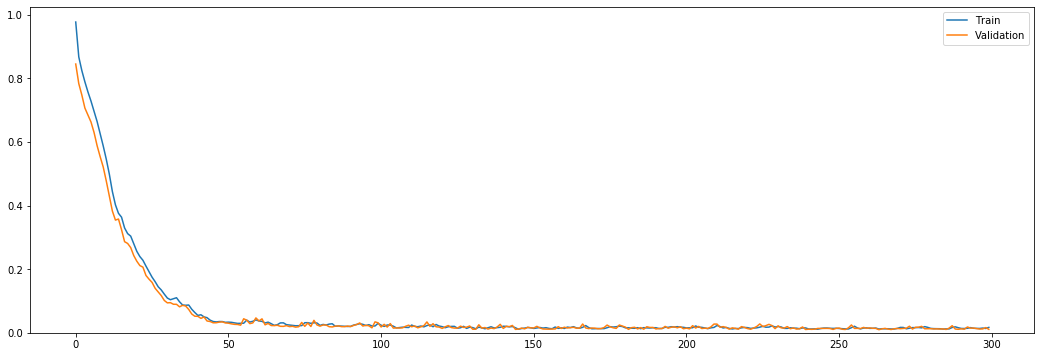

In [11]:
plot_loss(history)

In [12]:
y_pred = model.predict(X_val)

In [13]:
y_pred[0:2]

array([[0.41627392, 0.49073523, 0.6140703 , 0.6721957 , 0.75218207,
        0.8328166 , 0.8844395 , 1.0082208 , 1.0816269 ],
       [0.86093104, 1.012857  , 1.264093  , 1.3270464 , 1.502962  ,
        1.6741347 , 1.7410085 , 1.9907993 , 2.1358807 ]], dtype=float32)

## Rewrite to multi-output for each quantile

In [14]:
def get_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    
    #out_q0 = Dense(1, name="q0")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q0 = Dense(1, name="q0")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q1 = Dense(1, name="q1")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q2 = Dense(1, name="q2")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q3 = Dense(1, name="q3")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q4 = Dense(1, name="q4")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q5 = Dense(1, name="q5")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q6 = Dense(1, name="q6")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q7 = Dense(1, name="q7")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q8 = Dense(1, name="q8")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    
#     out_q0 = DistributionLayer(quantiles[0],x)
#     out_q1 = DistributionLayer(quantiles[1],x)
#     out_q2 = DistributionLayer(quantiles[2],x)
#     out_q3 = DistributionLayer(quantiles[3],x)
#     out_q4 = DistributionLayer(quantiles[4],x)
#     out_q5 = DistributionLayer(quantiles[5],x)
#     out_q6 = DistributionLayer(quantiles[6],x)
#     out_q7 = DistributionLayer(quantiles[7],x)
#     out_q8 = DistributionLayer(quantiles[8],x)

    model = Model(inputs=inp, outputs=[out_q0, out_q1, out_q2, out_q3, out_q4, out_q5, out_q6, out_q7, out_q8])

    return model

In [15]:
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss="MAE")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [16]:
y_train_mo = {'q'+str(i): y_train[:, i] for i in range(len(quantiles))}
y_val_mo = {'q'+str(i): y_val[:, i] for i in range(len(quantiles))}
y_train_mo

{'q0': array([0.77976871, 0.4255634 , 0.41740025, 0.42903284, 0.82754025,
        0.4064456 , 0.40616237, 0.45264247, 0.41096554, 0.41689168,
        0.38520678, 0.41300217, 0.40747019, 0.86864485, 0.43559714,
        0.42313449, 0.41549744, 0.43160425, 0.4241328 , 0.39397524,
        0.45516087, 0.92357664, 0.41138681, 0.4042906 , 0.84447597,
        0.42392267, 0.7718635 , 0.44973176, 0.43213789, 0.84063285,
        0.82372458, 0.78483486, 0.41210167, 0.43546165, 0.92956534,
        0.44674431, 0.40117869, 0.44582427, 0.83591121, 0.87259832,
        0.90353443, 0.42208748, 0.38899553, 0.45153601, 0.39837333,
        0.41525051, 0.42364229, 0.86586664, 0.40607733, 0.41816087,
        0.38255025, 0.89064516, 0.42218558, 0.42119283, 0.40201799,
        0.90192745, 0.40566299, 0.42338319, 0.41504695, 0.43416054,
        0.40994688, 0.41956467, 0.86222354, 0.40953107, 0.87499344,
        0.43268808, 0.40363463, 0.43650302, 0.41236164, 0.91755915,
        0.84431159, 0.79940419, 0.41597326

In [17]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

Train on 269 samples, validate on 68 samples
Epoch 1/300
269/269 [==============================] - 2s 9ms/sample - loss: 9.7113 - q0_loss: 1.2906 - q1_loss: 0.5838 - q2_loss: 1.4917 - q3_loss: 0.9498 - q4_loss: 0.9518 - q5_loss: 0.9886 - q6_loss: 1.1719 - q7_loss: 1.0766 - q8_loss: 1.0933 - val_loss: 7.3981 - val_q0_loss: 1.7241 - val_q1_loss: 0.4904 - val_q2_loss: 1.3844 - val_q3_loss: 0.4641 - val_q4_loss: 0.5886 - val_q5_loss: 0.8873 - val_q6_loss: 0.3737 - val_q7_loss: 0.6349 - val_q8_loss: 0.6724
Epoch 2/300
269/269 [==============================] - 0s 242us/sample - loss: 7.7722 - q0_loss: 1.2897 - q1_loss: 0.4252 - q2_loss: 1.3371 - q3_loss: 0.7482 - q4_loss: 0.7116 - q5_loss: 0.9840 - q6_loss: 0.5416 - q7_loss: 0.8652 - q8_loss: 0.8986 - val_loss: 6.8688 - val_q0_loss: 1.5727 - val_q1_loss: 0.3832 - val_q2_loss: 1.4474 - val_q3_loss: 0.5159 - val_q4_loss: 0.4702 - val_q5_loss: 0.8171 - val_q6_loss: 0.2388 - val_q7_loss: 0.5339 - val_q8_loss: 0.5446
Epoch 3/300
269/269 [======

269/269 [==============================] - 0s 193us/sample - loss: 4.3756 - q0_loss: 1.3157 - q1_loss: 0.0948 - q2_loss: 1.3681 - q3_loss: 0.3847 - q4_loss: 0.1421 - q5_loss: 0.5807 - q6_loss: 0.1140 - q7_loss: 0.1497 - q8_loss: 0.2217 - val_loss: 3.9924 - val_q0_loss: 1.2626 - val_q1_loss: 0.0429 - val_q2_loss: 1.1269 - val_q3_loss: 0.1986 - val_q4_loss: 0.1073 - val_q5_loss: 0.5435 - val_q6_loss: 0.1420 - val_q7_loss: 0.0796 - val_q8_loss: 0.2755
Epoch 19/300
269/269 [==============================] - 0s 190us/sample - loss: 4.0726 - q0_loss: 1.3697 - q1_loss: 0.0553 - q2_loss: 1.3991 - q3_loss: 0.3490 - q4_loss: 0.0758 - q5_loss: 0.5598 - q6_loss: 0.0888 - q7_loss: 0.0754 - q8_loss: 0.1686 - val_loss: 3.7617 - val_q0_loss: 1.2574 - val_q1_loss: 0.0626 - val_q2_loss: 1.2171 - val_q3_loss: 0.2167 - val_q4_loss: 0.1000 - val_q5_loss: 0.4532 - val_q6_loss: 0.0553 - val_q7_loss: 0.1106 - val_q8_loss: 0.0810
Epoch 20/300
269/269 [==============================] - 0s 186us/sample - loss: 3

Epoch 36/300
269/269 [==============================] - 0s 193us/sample - loss: 2.6100 - q0_loss: 0.8637 - q1_loss: 0.0667 - q2_loss: 1.0324 - q3_loss: 0.1246 - q4_loss: 0.0969 - q5_loss: 0.1764 - q6_loss: 0.0672 - q7_loss: 0.1038 - q8_loss: 0.0700 - val_loss: 2.5017 - val_q0_loss: 0.8600 - val_q1_loss: 0.0519 - val_q2_loss: 0.8476 - val_q3_loss: 0.1027 - val_q4_loss: 0.1062 - val_q5_loss: 0.1622 - val_q6_loss: 0.0963 - val_q7_loss: 0.0961 - val_q8_loss: 0.0592
Epoch 37/300
269/269 [==============================] - 0s 197us/sample - loss: 2.5264 - q0_loss: 0.8889 - q1_loss: 0.0449 - q2_loss: 1.0189 - q3_loss: 0.0992 - q4_loss: 0.0632 - q5_loss: 0.1568 - q6_loss: 0.0842 - q7_loss: 0.0615 - q8_loss: 0.0846 - val_loss: 2.1027 - val_q0_loss: 0.7538 - val_q1_loss: 0.0206 - val_q2_loss: 0.8416 - val_q3_loss: 0.0589 - val_q4_loss: 0.0288 - val_q5_loss: 0.1195 - val_q6_loss: 0.0550 - val_q7_loss: 0.0270 - val_q8_loss: 0.0328
Epoch 38/300
269/269 [==============================] - 0s 171us/sam

Epoch 54/300
269/269 [==============================] - 0s 176us/sample - loss: 1.4571 - q0_loss: 0.4063 - q1_loss: 0.0275 - q2_loss: 0.6605 - q3_loss: 0.0706 - q4_loss: 0.0237 - q5_loss: 0.0892 - q6_loss: 0.0665 - q7_loss: 0.0288 - q8_loss: 0.0597 - val_loss: 1.2358 - val_q0_loss: 0.2580 - val_q1_loss: 0.0289 - val_q2_loss: 0.5248 - val_q3_loss: 0.0464 - val_q4_loss: 0.0360 - val_q5_loss: 0.0675 - val_q6_loss: 0.0374 - val_q7_loss: 0.0458 - val_q8_loss: 0.0391
Epoch 55/300
269/269 [==============================] - 0s 130us/sample - loss: 1.3647 - q0_loss: 0.3722 - q1_loss: 0.0270 - q2_loss: 0.6365 - q3_loss: 0.0687 - q4_loss: 0.0277 - q5_loss: 0.0841 - q6_loss: 0.0458 - q7_loss: 0.0334 - q8_loss: 0.0406 - val_loss: 1.2189 - val_q0_loss: 0.2012 - val_q1_loss: 0.0502 - val_q2_loss: 0.5007 - val_q3_loss: 0.0521 - val_q4_loss: 0.0669 - val_q5_loss: 0.0611 - val_q6_loss: 0.0362 - val_q7_loss: 0.0808 - val_q8_loss: 0.0285
Epoch 56/300
269/269 [==============================] - 0s 265us/sam

Epoch 72/300
269/269 [==============================] - 0s 190us/sample - loss: 0.9078 - q0_loss: 0.2127 - q1_loss: 0.0344 - q2_loss: 0.2991 - q3_loss: 0.0725 - q4_loss: 0.0494 - q5_loss: 0.0716 - q6_loss: 0.0487 - q7_loss: 0.0604 - q8_loss: 0.0472 - val_loss: 0.7166 - val_q0_loss: 0.1342 - val_q1_loss: 0.0285 - val_q2_loss: 0.1776 - val_q3_loss: 0.0378 - val_q4_loss: 0.0280 - val_q5_loss: 0.0437 - val_q6_loss: 0.0743 - val_q7_loss: 0.0441 - val_q8_loss: 0.0554
Epoch 73/300
269/269 [==============================] - 0s 191us/sample - loss: 0.9026 - q0_loss: 0.2296 - q1_loss: 0.0349 - q2_loss: 0.2858 - q3_loss: 0.0784 - q4_loss: 0.0552 - q5_loss: 0.0754 - q6_loss: 0.0490 - q7_loss: 0.0612 - q8_loss: 0.0447 - val_loss: 0.8777 - val_q0_loss: 0.1584 - val_q1_loss: 0.0501 - val_q2_loss: 0.1559 - val_q3_loss: 0.0522 - val_q4_loss: 0.0621 - val_q5_loss: 0.0588 - val_q6_loss: 0.0969 - val_q7_loss: 0.0830 - val_q8_loss: 0.0834
Epoch 74/300
269/269 [==============================] - 0s 229us/sam

Epoch 90/300
269/269 [==============================] - 0s 174us/sample - loss: 0.6241 - q0_loss: 0.1961 - q1_loss: 0.0145 - q2_loss: 0.2115 - q3_loss: 0.0568 - q4_loss: 0.0198 - q5_loss: 0.0473 - q6_loss: 0.0349 - q7_loss: 0.0226 - q8_loss: 0.0271 - val_loss: 0.5049 - val_q0_loss: 0.1325 - val_q1_loss: 0.0145 - val_q2_loss: 0.1113 - val_q3_loss: 0.0459 - val_q4_loss: 0.0193 - val_q5_loss: 0.0395 - val_q6_loss: 0.0187 - val_q7_loss: 0.0212 - val_q8_loss: 0.0240
Epoch 91/300
269/269 [==============================] - 0s 177us/sample - loss: 0.6207 - q0_loss: 0.2008 - q1_loss: 0.0171 - q2_loss: 0.2111 - q3_loss: 0.0521 - q4_loss: 0.0218 - q5_loss: 0.0452 - q6_loss: 0.0320 - q7_loss: 0.0250 - q8_loss: 0.0238 - val_loss: 0.4791 - val_q0_loss: 0.1416 - val_q1_loss: 0.0109 - val_q2_loss: 0.1117 - val_q3_loss: 0.0334 - val_q4_loss: 0.0073 - val_q5_loss: 0.0328 - val_q6_loss: 0.0195 - val_q7_loss: 0.0132 - val_q8_loss: 0.0188
Epoch 92/300
269/269 [==============================] - 0s 188us/sam

Epoch 108/300
269/269 [==============================] - 0s 178us/sample - loss: 0.6488 - q0_loss: 0.1688 - q1_loss: 0.0295 - q2_loss: 0.1902 - q3_loss: 0.0527 - q4_loss: 0.0459 - q5_loss: 0.0287 - q6_loss: 0.0336 - q7_loss: 0.0512 - q8_loss: 0.0314 - val_loss: 0.4955 - val_q0_loss: 0.1486 - val_q1_loss: 0.0176 - val_q2_loss: 0.1075 - val_q3_loss: 0.0255 - val_q4_loss: 0.0248 - val_q5_loss: 0.0266 - val_q6_loss: 0.0275 - val_q7_loss: 0.0290 - val_q8_loss: 0.0196
Epoch 109/300
269/269 [==============================] - 0s 175us/sample - loss: 0.5653 - q0_loss: 0.1697 - q1_loss: 0.0167 - q2_loss: 0.1865 - q3_loss: 0.0417 - q4_loss: 0.0228 - q5_loss: 0.0249 - q6_loss: 0.0312 - q7_loss: 0.0254 - q8_loss: 0.0271 - val_loss: 0.5107 - val_q0_loss: 0.1107 - val_q1_loss: 0.0268 - val_q2_loss: 0.1050 - val_q3_loss: 0.0535 - val_q4_loss: 0.0401 - val_q5_loss: 0.0290 - val_q6_loss: 0.0247 - val_q7_loss: 0.0430 - val_q8_loss: 0.0271
Epoch 110/300
269/269 [==============================] - 0s 202us/

Epoch 126/300
269/269 [==============================] - 0s 178us/sample - loss: 0.5752 - q0_loss: 0.1618 - q1_loss: 0.0270 - q2_loss: 0.1778 - q3_loss: 0.0339 - q4_loss: 0.0435 - q5_loss: 0.0194 - q6_loss: 0.0255 - q7_loss: 0.0468 - q8_loss: 0.0306 - val_loss: 0.4447 - val_q0_loss: 0.1310 - val_q1_loss: 0.0129 - val_q2_loss: 0.1001 - val_q3_loss: 0.0215 - val_q4_loss: 0.0209 - val_q5_loss: 0.0269 - val_q6_loss: 0.0234 - val_q7_loss: 0.0183 - val_q8_loss: 0.0294
Epoch 127/300
269/269 [==============================] - 0s 171us/sample - loss: 0.5578 - q0_loss: 0.1539 - q1_loss: 0.0243 - q2_loss: 0.1852 - q3_loss: 0.0366 - q4_loss: 0.0394 - q5_loss: 0.0208 - q6_loss: 0.0283 - q7_loss: 0.0412 - q8_loss: 0.0337 - val_loss: 0.4290 - val_q0_loss: 0.0898 - val_q1_loss: 0.0201 - val_q2_loss: 0.0974 - val_q3_loss: 0.0329 - val_q4_loss: 0.0295 - val_q5_loss: 0.0127 - val_q6_loss: 0.0325 - val_q7_loss: 0.0283 - val_q8_loss: 0.0294
Epoch 128/300
269/269 [==============================] - 0s 182us/

Epoch 144/300
269/269 [==============================] - 0s 182us/sample - loss: 0.5434 - q0_loss: 0.1278 - q1_loss: 0.0303 - q2_loss: 0.1724 - q3_loss: 0.0351 - q4_loss: 0.0460 - q5_loss: 0.0233 - q6_loss: 0.0283 - q7_loss: 0.0530 - q8_loss: 0.0418 - val_loss: 0.4898 - val_q0_loss: 0.1067 - val_q1_loss: 0.0273 - val_q2_loss: 0.0895 - val_q3_loss: 0.0315 - val_q4_loss: 0.0479 - val_q5_loss: 0.0168 - val_q6_loss: 0.0283 - val_q7_loss: 0.0517 - val_q8_loss: 0.0342
Epoch 145/300
269/269 [==============================] - 0s 169us/sample - loss: 0.5349 - q0_loss: 0.1163 - q1_loss: 0.0224 - q2_loss: 0.1606 - q3_loss: 0.0258 - q4_loss: 0.0300 - q5_loss: 0.0355 - q6_loss: 0.0433 - q7_loss: 0.0390 - q8_loss: 0.0568 - val_loss: 0.5439 - val_q0_loss: 0.0773 - val_q1_loss: 0.0204 - val_q2_loss: 0.0890 - val_q3_loss: 0.0235 - val_q4_loss: 0.0335 - val_q5_loss: 0.0560 - val_q6_loss: 0.0714 - val_q7_loss: 0.0314 - val_q8_loss: 0.0798
Epoch 146/300
269/269 [==============================] - 0s 171us/

Epoch 162/300
269/269 [==============================] - 0s 190us/sample - loss: 0.5869 - q0_loss: 0.1288 - q1_loss: 0.0305 - q2_loss: 0.1524 - q3_loss: 0.0311 - q4_loss: 0.0559 - q5_loss: 0.0338 - q6_loss: 0.0432 - q7_loss: 0.0533 - q8_loss: 0.0491 - val_loss: 0.7350 - val_q0_loss: 0.1041 - val_q1_loss: 0.0754 - val_q2_loss: 0.0801 - val_q3_loss: 0.0798 - val_q4_loss: 0.1318 - val_q5_loss: 0.0263 - val_q6_loss: 0.0432 - val_q7_loss: 0.1313 - val_q8_loss: 0.0347
Epoch 163/300
269/269 [==============================] - 0s 175us/sample - loss: 0.6382 - q0_loss: 0.1066 - q1_loss: 0.0497 - q2_loss: 0.1448 - q3_loss: 0.0557 - q4_loss: 0.0805 - q5_loss: 0.0279 - q6_loss: 0.0312 - q7_loss: 0.0880 - q8_loss: 0.0409 - val_loss: 0.5246 - val_q0_loss: 0.0665 - val_q1_loss: 0.0257 - val_q2_loss: 0.0786 - val_q3_loss: 0.0328 - val_q4_loss: 0.0409 - val_q5_loss: 0.0521 - val_q6_loss: 0.0600 - val_q7_loss: 0.0486 - val_q8_loss: 0.0710
Epoch 164/300
269/269 [==============================] - 0s 177us/

Epoch 180/300
269/269 [==============================] - 0s 177us/sample - loss: 0.3685 - q0_loss: 0.0698 - q1_loss: 0.0125 - q2_loss: 0.1362 - q3_loss: 0.0101 - q4_loss: 0.0180 - q5_loss: 0.0318 - q6_loss: 0.0377 - q7_loss: 0.0197 - q8_loss: 0.0461 - val_loss: 0.3390 - val_q0_loss: 0.0867 - val_q1_loss: 0.0145 - val_q2_loss: 0.0770 - val_q3_loss: 0.0124 - val_q4_loss: 0.0141 - val_q5_loss: 0.0297 - val_q6_loss: 0.0318 - val_q7_loss: 0.0185 - val_q8_loss: 0.0409
Epoch 181/300
269/269 [==============================] - 0s 186us/sample - loss: 0.3912 - q0_loss: 0.0692 - q1_loss: 0.0195 - q2_loss: 0.1217 - q3_loss: 0.0186 - q4_loss: 0.0269 - q5_loss: 0.0269 - q6_loss: 0.0310 - q7_loss: 0.0315 - q8_loss: 0.0444 - val_loss: 0.5487 - val_q0_loss: 0.0630 - val_q1_loss: 0.0456 - val_q2_loss: 0.0813 - val_q3_loss: 0.0546 - val_q4_loss: 0.0712 - val_q5_loss: 0.0445 - val_q6_loss: 0.0436 - val_q7_loss: 0.0842 - val_q8_loss: 0.0600
Epoch 182/300
269/269 [==============================] - 0s 173us/

Epoch 198/300
269/269 [==============================] - 0s 116us/sample - loss: 0.3387 - q0_loss: 0.0334 - q1_loss: 0.0202 - q2_loss: 0.1024 - q3_loss: 0.0219 - q4_loss: 0.0257 - q5_loss: 0.0269 - q6_loss: 0.0283 - q7_loss: 0.0323 - q8_loss: 0.0398 - val_loss: 0.4255 - val_q0_loss: 0.0390 - val_q1_loss: 0.0215 - val_q2_loss: 0.0608 - val_q3_loss: 0.0301 - val_q4_loss: 0.0250 - val_q5_loss: 0.0564 - val_q6_loss: 0.0622 - val_q7_loss: 0.0397 - val_q8_loss: 0.0716
Epoch 199/300
269/269 [==============================] - 0s 116us/sample - loss: 0.3346 - q0_loss: 0.0488 - q1_loss: 0.0156 - q2_loss: 0.1023 - q3_loss: 0.0145 - q4_loss: 0.0197 - q5_loss: 0.0296 - q6_loss: 0.0331 - q7_loss: 0.0238 - q8_loss: 0.0430 - val_loss: 0.3150 - val_q0_loss: 0.0435 - val_q1_loss: 0.0203 - val_q2_loss: 0.0566 - val_q3_loss: 0.0170 - val_q4_loss: 0.0331 - val_q5_loss: 0.0243 - val_q6_loss: 0.0303 - val_q7_loss: 0.0327 - val_q8_loss: 0.0311
Epoch 200/300
269/269 [==============================] - 0s 116us/

Epoch 216/300
269/269 [==============================] - 0s 182us/sample - loss: 0.3797 - q0_loss: 0.0451 - q1_loss: 0.0275 - q2_loss: 0.0778 - q3_loss: 0.0305 - q4_loss: 0.0441 - q5_loss: 0.0294 - q6_loss: 0.0312 - q7_loss: 0.0508 - q8_loss: 0.0438 - val_loss: 0.2964 - val_q0_loss: 0.0309 - val_q1_loss: 0.0263 - val_q2_loss: 0.0425 - val_q3_loss: 0.0305 - val_q4_loss: 0.0389 - val_q5_loss: 0.0225 - val_q6_loss: 0.0235 - val_q7_loss: 0.0464 - val_q8_loss: 0.0358
Epoch 217/300
269/269 [==============================] - 0s 189us/sample - loss: 0.2806 - q0_loss: 0.0403 - q1_loss: 0.0169 - q2_loss: 0.0756 - q3_loss: 0.0157 - q4_loss: 0.0244 - q5_loss: 0.0196 - q6_loss: 0.0219 - q7_loss: 0.0281 - q8_loss: 0.0323 - val_loss: 0.4225 - val_q0_loss: 0.0831 - val_q1_loss: 0.0301 - val_q2_loss: 0.0448 - val_q3_loss: 0.0255 - val_q4_loss: 0.0544 - val_q5_loss: 0.0359 - val_q6_loss: 0.0438 - val_q7_loss: 0.0492 - val_q8_loss: 0.0464
Epoch 218/300
269/269 [==============================] - 0s 185us/

Epoch 234/300
269/269 [==============================] - 0s 175us/sample - loss: 0.2196 - q0_loss: 0.0334 - q1_loss: 0.0127 - q2_loss: 0.0510 - q3_loss: 0.0115 - q4_loss: 0.0154 - q5_loss: 0.0205 - q6_loss: 0.0223 - q7_loss: 0.0183 - q8_loss: 0.0343 - val_loss: 0.1852 - val_q0_loss: 0.0286 - val_q1_loss: 0.0148 - val_q2_loss: 0.0425 - val_q3_loss: 0.0119 - val_q4_loss: 0.0138 - val_q5_loss: 0.0163 - val_q6_loss: 0.0178 - val_q7_loss: 0.0181 - val_q8_loss: 0.0251
Epoch 235/300
269/269 [==============================] - 0s 186us/sample - loss: 0.1864 - q0_loss: 0.0259 - q1_loss: 0.0125 - q2_loss: 0.0467 - q3_loss: 0.0099 - q4_loss: 0.0101 - q5_loss: 0.0161 - q6_loss: 0.0180 - q7_loss: 0.0159 - q8_loss: 0.0286 - val_loss: 0.1648 - val_q0_loss: 0.0270 - val_q1_loss: 0.0114 - val_q2_loss: 0.0294 - val_q3_loss: 0.0068 - val_q4_loss: 0.0095 - val_q5_loss: 0.0151 - val_q6_loss: 0.0163 - val_q7_loss: 0.0116 - val_q8_loss: 0.0203
Epoch 236/300
269/269 [==============================] - 0s 223us/

Epoch 252/300
269/269 [==============================] - 0s 186us/sample - loss: 0.2324 - q0_loss: 0.0440 - q1_loss: 0.0173 - q2_loss: 0.0255 - q3_loss: 0.0153 - q4_loss: 0.0267 - q5_loss: 0.0212 - q6_loss: 0.0246 - q7_loss: 0.0281 - q8_loss: 0.0319 - val_loss: 0.2138 - val_q0_loss: 0.0423 - val_q1_loss: 0.0123 - val_q2_loss: 0.0153 - val_q3_loss: 0.0081 - val_q4_loss: 0.0126 - val_q5_loss: 0.0300 - val_q6_loss: 0.0333 - val_q7_loss: 0.0123 - val_q8_loss: 0.0427
Epoch 253/300
269/269 [==============================] - 0s 168us/sample - loss: 0.1902 - q0_loss: 0.0343 - q1_loss: 0.0144 - q2_loss: 0.0202 - q3_loss: 0.0135 - q4_loss: 0.0190 - q5_loss: 0.0168 - q6_loss: 0.0192 - q7_loss: 0.0235 - q8_loss: 0.0299 - val_loss: 0.1715 - val_q0_loss: 0.0352 - val_q1_loss: 0.0125 - val_q2_loss: 0.0293 - val_q3_loss: 0.0085 - val_q4_loss: 0.0123 - val_q5_loss: 0.0174 - val_q6_loss: 0.0194 - val_q7_loss: 0.0135 - val_q8_loss: 0.0251
Epoch 254/300
269/269 [==============================] - 0s 170us/

Epoch 270/300
269/269 [==============================] - 0s 171us/sample - loss: 0.1997 - q0_loss: 0.0253 - q1_loss: 0.0200 - q2_loss: 0.0101 - q3_loss: 0.0219 - q4_loss: 0.0296 - q5_loss: 0.0138 - q6_loss: 0.0138 - q7_loss: 0.0355 - q8_loss: 0.0280 - val_loss: 0.1264 - val_q0_loss: 0.0207 - val_q1_loss: 0.0132 - val_q2_loss: 0.0091 - val_q3_loss: 0.0100 - val_q4_loss: 0.0121 - val_q5_loss: 0.0116 - val_q6_loss: 0.0123 - val_q7_loss: 0.0167 - val_q8_loss: 0.0238
Epoch 271/300
269/269 [==============================] - 0s 181us/sample - loss: 0.1487 - q0_loss: 0.0254 - q1_loss: 0.0144 - q2_loss: 0.0098 - q3_loss: 0.0122 - q4_loss: 0.0169 - q5_loss: 0.0112 - q6_loss: 0.0120 - q7_loss: 0.0225 - q8_loss: 0.0242 - val_loss: 0.2084 - val_q0_loss: 0.0365 - val_q1_loss: 0.0122 - val_q2_loss: 0.0222 - val_q3_loss: 0.0097 - val_q4_loss: 0.0106 - val_q5_loss: 0.0283 - val_q6_loss: 0.0316 - val_q7_loss: 0.0152 - val_q8_loss: 0.0354
Epoch 272/300
269/269 [==============================] - 0s 170us/

Epoch 288/300
269/269 [==============================] - 0s 182us/sample - loss: 0.1728 - q0_loss: 0.0341 - q1_loss: 0.0119 - q2_loss: 0.0173 - q3_loss: 0.0088 - q4_loss: 0.0115 - q5_loss: 0.0197 - q6_loss: 0.0220 - q7_loss: 0.0154 - q8_loss: 0.0312 - val_loss: 0.1254 - val_q0_loss: 0.0220 - val_q1_loss: 0.0121 - val_q2_loss: 0.0102 - val_q3_loss: 0.0066 - val_q4_loss: 0.0076 - val_q5_loss: 0.0128 - val_q6_loss: 0.0143 - val_q7_loss: 0.0114 - val_q8_loss: 0.0196
Epoch 289/300
269/269 [==============================] - 0s 193us/sample - loss: 0.1456 - q0_loss: 0.0277 - q1_loss: 0.0117 - q2_loss: 0.0123 - q3_loss: 0.0093 - q4_loss: 0.0118 - q5_loss: 0.0145 - q6_loss: 0.0159 - q7_loss: 0.0165 - q8_loss: 0.0277 - val_loss: 0.1299 - val_q0_loss: 0.0191 - val_q1_loss: 0.0116 - val_q2_loss: 0.0103 - val_q3_loss: 0.0095 - val_q4_loss: 0.0100 - val_q5_loss: 0.0132 - val_q6_loss: 0.0138 - val_q7_loss: 0.0154 - val_q8_loss: 0.0199
Epoch 290/300
269/269 [==============================] - 0s 197us/

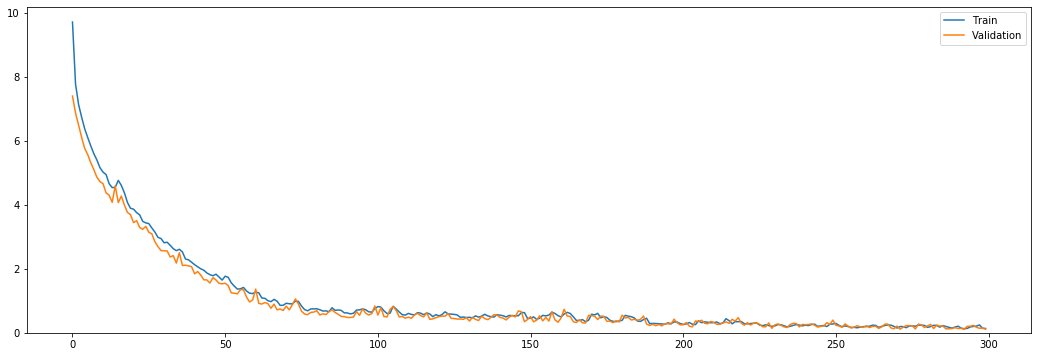

In [18]:
plot_loss(history)

In [19]:
y_pred = model.predict(X_val)

# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[0.41997665, 0.4949456 , 0.62329924, 0.66063225, 0.74756277,
        0.83652973, 0.8758861 , 1.0009358 , 1.0780622 ],
       [0.85371   , 1.0035434 , 1.2454813 , 1.3203863 , 1.4883837 ,
        1.6583601 , 1.7337118 , 1.9776263 , 2.1205285 ]], dtype=float32)

**Note**: training seems slower! 

## Implement custom layer

In [55]:
# from https://www.wolframalpha.com/input/?i=percentiles+of+a+normal+distribution
sigma_coefs = [-2.57583, -1.95996, -0.974114, -0.674, 0, 0.674, 0.9741114, 1.95996, 2.57583]

# Lambda layer: https://blog.paperspace.com/working-with-the-lambda-layer-in-keras/
def get_custom_layer(sigma_coefs,i):
    def custom_layer(tensor):
        tensor1 = tensor[0]
        tensor2 = tensor[1]
        kurtosis = tensor[2]
        skewness = tensor[3]
    
        
        sigma_coef_max=np.max(sigma_coefs)
        if (i in [1,2,3,5,6,7]): 
            
            # apply skewness (-1,1) to coefficient
            mod_sigma_coefs= sigma_coefs[i]+(sigma_coef_max-sigma_coefs[i])*skewness
            
            # shift x-coordinates towards mean for normalised kurtosis of 1
            return tensor1 + mod_sigma_coefs*(1-kurtosis) * tensor2 ;
        else: 
            # apply skewness
            if (i==4):
                # apply skewness
                spoofed_sigma_coefs_5=-sigma_coefs[3]+(sigma_coef_max+sigma_coefs[3])*skewness
                spoofed_sigma_coefs_3=sigma_coefs[3]+(sigma_coef_max-sigma_coefs[3])*skewness
                mod_sigma_coefs =spoofed_sigma_coefs_3+(spoofed_sigma_coefs_5-spoofed_sigma_coefs_3)/2

                # shift x-coordinates towards mean for normalised kurtosis of 1
                return tensor1 + mod_sigma_coefs*(1-kurtosis) * tensor2 ;
            
            # keep outer(0,8) and middle quantile(4) x-coordinate the same for kurtosis
            else:
                return tensor1 + sigma_coefs[i] * tensor2
    return custom_layer      
    
# dummy function to test the implemented skewness implementation
def apply_skewness(sigma_coefs,skewness):
    mod_sigma_coefs= np.zeros((len(sigma_coefs)),dtype=float)
    sigma_coef_max=np.max(sigma_coefs)
    for i in range(0,len(sigma_coefs)):
        if (i in [1,2,3,5,6,7]): 
            mod_sigma_coefs[i]=sigma_coefs[i]+(sigma_coef_max-sigma_coefs[i])*skewness
    
    # center new mean by computing sigma_coefs[5] using only sigma_coefs[3] (and 4) 
    spoofed_sigma_coefs_5=-sigma_coefs[3]+(sigma_coef_max+sigma_coefs[3])*skewness
    mod_sigma_coefs[4]=mod_sigma_coefs[3]+(spoofed_sigma_coefs_5-mod_sigma_coefs[3])/2    
    return mod_sigma_coefs        
    
def get_dist_model(inp_shape, sigma_coefs):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)

    mu = Dense(1)(x)  # represents mu
    sigma = Dense(1)(x)  # represents sigma
    kurtosis = Dense(1)(x) # represents kurtosis
    skewness = Dense(1)(x) # represents skewness
    outs = []

    print(f'skewed sigma_coefs={apply_skewness(sigma_coefs,0.4)}')
    print(f'skewed sigma_coefs={apply_skewness(sigma_coefs,-0.4)}')
    
    for i, sigma_coef in enumerate(sigma_coefs):
        custom_layer = get_custom_layer(sigma_coefs=sigma_coefs,i=i)
        out_q = Lambda(custom_layer, name="q{}".format(i))([mu, sigma, kurtosis,skewness])
        outs.append(out_q)

    model = Model(inputs=inp, outputs=outs) 

    return model

In [56]:
model = get_dist_model(inp_shape=(train_df.columns.size,), sigma_coefs=sigma_coefs)
model.compile(optimizer="adam", loss="MAE")
model.summary()

skewed sigma_coefs=[ 0.         -0.145644    0.4458636   0.625932    1.030332    1.434732
  1.61479884  2.206308    0.        ]
skewed sigma_coefs=[ 0.         -3.774276   -2.3940916  -1.973932   -1.030332   -0.086732
  0.33342396  1.713612    0.        ]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
____________________________________

In [22]:
y_train_mo = {'q'+str(i): y_train[:, i] for i in range(len(quantiles))}
y_val_mo = {'q'+str(i): y_val[:, i] for i in range(len(quantiles))}
y_train_mo

{'q0': array([0.77976871, 0.4255634 , 0.41740025, 0.42903284, 0.82754025,
        0.4064456 , 0.40616237, 0.45264247, 0.41096554, 0.41689168,
        0.38520678, 0.41300217, 0.40747019, 0.86864485, 0.43559714,
        0.42313449, 0.41549744, 0.43160425, 0.4241328 , 0.39397524,
        0.45516087, 0.92357664, 0.41138681, 0.4042906 , 0.84447597,
        0.42392267, 0.7718635 , 0.44973176, 0.43213789, 0.84063285,
        0.82372458, 0.78483486, 0.41210167, 0.43546165, 0.92956534,
        0.44674431, 0.40117869, 0.44582427, 0.83591121, 0.87259832,
        0.90353443, 0.42208748, 0.38899553, 0.45153601, 0.39837333,
        0.41525051, 0.42364229, 0.86586664, 0.40607733, 0.41816087,
        0.38255025, 0.89064516, 0.42218558, 0.42119283, 0.40201799,
        0.90192745, 0.40566299, 0.42338319, 0.41504695, 0.43416054,
        0.40994688, 0.41956467, 0.86222354, 0.40953107, 0.87499344,
        0.43268808, 0.40363463, 0.43650302, 0.41236164, 0.91755915,
        0.84431159, 0.79940419, 0.41597326

In [23]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

Train on 269 samples, validate on 68 samples
Epoch 1/300
269/269 [==============================] - 3s 12ms/sample - loss: 11.0388 - q0_loss: 2.3826 - q1_loss: 0.7490 - q2_loss: 0.6593 - q3_loss: 0.6432 - q4_loss: 0.6644 - q5_loss: 0.7726 - q6_loss: 0.8322 - q7_loss: 1.0538 - q8_loss: 3.1824 - val_loss: 8.4696 - val_q0_loss: 1.8794 - val_q1_loss: 0.8335 - val_q2_loss: 0.7045 - val_q3_loss: 0.6742 - val_q4_loss: 0.6313 - val_q5_loss: 0.6036 - val_q6_loss: 0.6068 - val_q7_loss: 0.6771 - val_q8_loss: 2.0296
Epoch 2/300
269/269 [==============================] - 0s 189us/sample - loss: 6.2062 - q0_loss: 1.1395 - q1_loss: 0.5449 - q2_loss: 0.4965 - q3_loss: 0.4883 - q4_loss: 0.4879 - q5_loss: 0.5183 - q6_loss: 0.5442 - q7_loss: 0.6611 - q8_loss: 1.1883 - val_loss: 4.3473 - val_q0_loss: 0.7146 - val_q1_loss: 0.3846 - val_q2_loss: 0.3248 - val_q3_loss: 0.3196 - val_q4_loss: 0.3457 - val_q5_loss: 0.4007 - val_q6_loss: 0.4352 - val_q7_loss: 0.5528 - val_q8_loss: 0.5566
Epoch 3/300
269/269 [====

269/269 [==============================] - 0s 197us/sample - loss: 0.4700 - q0_loss: 0.1080 - q1_loss: 0.0666 - q2_loss: 0.0468 - q3_loss: 0.0418 - q4_loss: 0.0321 - q5_loss: 0.0334 - q6_loss: 0.0355 - q7_loss: 0.0479 - q8_loss: 0.0640 - val_loss: 0.5143 - val_q0_loss: 0.1162 - val_q1_loss: 0.0835 - val_q2_loss: 0.0587 - val_q3_loss: 0.0515 - val_q4_loss: 0.0357 - val_q5_loss: 0.0288 - val_q6_loss: 0.0264 - val_q7_loss: 0.0379 - val_q8_loss: 0.0616
Epoch 19/300
269/269 [==============================] - 0s 193us/sample - loss: 0.4841 - q0_loss: 0.1016 - q1_loss: 0.0846 - q2_loss: 0.0634 - q3_loss: 0.0576 - q4_loss: 0.0439 - q5_loss: 0.0332 - q6_loss: 0.0290 - q7_loss: 0.0300 - q8_loss: 0.0410 - val_loss: 0.5626 - val_q0_loss: 0.0800 - val_q1_loss: 0.0513 - val_q2_loss: 0.0494 - val_q3_loss: 0.0510 - val_q4_loss: 0.0557 - val_q5_loss: 0.0617 - val_q6_loss: 0.0648 - val_q7_loss: 0.0754 - val_q8_loss: 0.0685
Epoch 20/300
269/269 [==============================] - 0s 216us/sample - loss: 0

Epoch 36/300
269/269 [==============================] - 0s 179us/sample - loss: 0.3646 - q0_loss: 0.0664 - q1_loss: 0.0604 - q2_loss: 0.0407 - q3_loss: 0.0360 - q4_loss: 0.0240 - q5_loss: 0.0205 - q6_loss: 0.0226 - q7_loss: 0.0374 - q8_loss: 0.0500 - val_loss: 0.4700 - val_q0_loss: 0.1221 - val_q1_loss: 0.0830 - val_q2_loss: 0.0603 - val_q3_loss: 0.0530 - val_q4_loss: 0.0360 - val_q5_loss: 0.0210 - val_q6_loss: 0.0182 - val_q7_loss: 0.0290 - val_q8_loss: 0.0696
Epoch 37/300
269/269 [==============================] - 0s 183us/sample - loss: 0.3488 - q0_loss: 0.0730 - q1_loss: 0.0566 - q2_loss: 0.0379 - q3_loss: 0.0330 - q4_loss: 0.0230 - q5_loss: 0.0181 - q6_loss: 0.0183 - q7_loss: 0.0305 - q8_loss: 0.0454 - val_loss: 0.4152 - val_q0_loss: 0.0685 - val_q1_loss: 0.0503 - val_q2_loss: 0.0475 - val_q3_loss: 0.0468 - val_q4_loss: 0.0452 - val_q5_loss: 0.0439 - val_q6_loss: 0.0432 - val_q7_loss: 0.0415 - val_q8_loss: 0.0343
Epoch 38/300
269/269 [==============================] - 0s 185us/sam

Epoch 54/300
269/269 [==============================] - 0s 186us/sample - loss: 0.3435 - q0_loss: 0.0788 - q1_loss: 0.0631 - q2_loss: 0.0453 - q3_loss: 0.0402 - q4_loss: 0.0289 - q5_loss: 0.0201 - q6_loss: 0.0175 - q7_loss: 0.0221 - q8_loss: 0.0316 - val_loss: 0.3478 - val_q0_loss: 0.0299 - val_q1_loss: 0.0639 - val_q2_loss: 0.0515 - val_q3_loss: 0.0488 - val_q4_loss: 0.0426 - val_q5_loss: 0.0367 - val_q6_loss: 0.0341 - val_q7_loss: 0.0265 - val_q8_loss: 0.0274
Epoch 55/300
269/269 [==============================] - 0s 190us/sample - loss: 0.3658 - q0_loss: 0.0782 - q1_loss: 0.0592 - q2_loss: 0.0423 - q3_loss: 0.0377 - q4_loss: 0.0299 - q5_loss: 0.0241 - q6_loss: 0.0237 - q7_loss: 0.0334 - q8_loss: 0.0442 - val_loss: 0.3175 - val_q0_loss: 0.0760 - val_q1_loss: 0.0404 - val_q2_loss: 0.0336 - val_q3_loss: 0.0310 - val_q4_loss: 0.0251 - val_q5_loss: 0.0204 - val_q6_loss: 0.0193 - val_q7_loss: 0.0294 - val_q8_loss: 0.0287
Epoch 56/300
269/269 [==============================] - 0s 201us/sam

Epoch 72/300
269/269 [==============================] - 0s 192us/sample - loss: 0.3515 - q0_loss: 0.0679 - q1_loss: 0.0559 - q2_loss: 0.0413 - q3_loss: 0.0375 - q4_loss: 0.0291 - q5_loss: 0.0238 - q6_loss: 0.0229 - q7_loss: 0.0284 - q8_loss: 0.0414 - val_loss: 0.2705 - val_q0_loss: 0.0264 - val_q1_loss: 0.0462 - val_q2_loss: 0.0367 - val_q3_loss: 0.0347 - val_q4_loss: 0.0307 - val_q5_loss: 0.0270 - val_q6_loss: 0.0257 - val_q7_loss: 0.0263 - val_q8_loss: 0.0402
Epoch 73/300
269/269 [==============================] - 0s 178us/sample - loss: 0.3326 - q0_loss: 0.0734 - q1_loss: 0.0585 - q2_loss: 0.0379 - q3_loss: 0.0326 - q4_loss: 0.0205 - q5_loss: 0.0147 - q6_loss: 0.0164 - q7_loss: 0.0305 - q8_loss: 0.0464 - val_loss: 0.4046 - val_q0_loss: 0.0642 - val_q1_loss: 0.0562 - val_q2_loss: 0.0297 - val_q3_loss: 0.0233 - val_q4_loss: 0.0153 - val_q5_loss: 0.0294 - val_q6_loss: 0.0371 - val_q7_loss: 0.0627 - val_q8_loss: 0.0703
Epoch 74/300
269/269 [==============================] - 0s 178us/sam

Epoch 90/300
269/269 [==============================] - 0s 178us/sample - loss: 0.2434 - q0_loss: 0.0349 - q1_loss: 0.0252 - q2_loss: 0.0161 - q3_loss: 0.0155 - q4_loss: 0.0170 - q5_loss: 0.0221 - q6_loss: 0.0252 - q7_loss: 0.0375 - q8_loss: 0.0489 - val_loss: 0.2072 - val_q0_loss: 0.0219 - val_q1_loss: 0.0217 - val_q2_loss: 0.0226 - val_q3_loss: 0.0224 - val_q4_loss: 0.0215 - val_q5_loss: 0.0214 - val_q6_loss: 0.0212 - val_q7_loss: 0.0218 - val_q8_loss: 0.0176
Epoch 91/300
269/269 [==============================] - 0s 178us/sample - loss: 0.3133 - q0_loss: 0.0553 - q1_loss: 0.0456 - q2_loss: 0.0340 - q3_loss: 0.0316 - q4_loss: 0.0264 - q5_loss: 0.0233 - q6_loss: 0.0230 - q7_loss: 0.0308 - q8_loss: 0.0421 - val_loss: 0.4175 - val_q0_loss: 0.0785 - val_q1_loss: 0.0774 - val_q2_loss: 0.0420 - val_q3_loss: 0.0329 - val_q4_loss: 0.0168 - val_q5_loss: 0.0230 - val_q6_loss: 0.0311 - val_q7_loss: 0.0645 - val_q8_loss: 0.0741
Epoch 92/300
269/269 [==============================] - 0s 186us/sam

Epoch 108/300
269/269 [==============================] - 0s 120us/sample - loss: 0.3021 - q0_loss: 0.0496 - q1_loss: 0.0380 - q2_loss: 0.0249 - q3_loss: 0.0217 - q4_loss: 0.0195 - q5_loss: 0.0231 - q6_loss: 0.0264 - q7_loss: 0.0408 - q8_loss: 0.0508 - val_loss: 0.3990 - val_q0_loss: 0.0891 - val_q1_loss: 0.0878 - val_q2_loss: 0.0562 - val_q3_loss: 0.0473 - val_q4_loss: 0.0278 - val_q5_loss: 0.0156 - val_q6_loss: 0.0173 - val_q7_loss: 0.0364 - val_q8_loss: 0.0427
Epoch 109/300
269/269 [==============================] - 0s 184us/sample - loss: 0.2750 - q0_loss: 0.0512 - q1_loss: 0.0421 - q2_loss: 0.0312 - q3_loss: 0.0283 - q4_loss: 0.0227 - q5_loss: 0.0190 - q6_loss: 0.0183 - q7_loss: 0.0252 - q8_loss: 0.0328 - val_loss: 0.2064 - val_q0_loss: 0.0250 - val_q1_loss: 0.0243 - val_q2_loss: 0.0093 - val_q3_loss: 0.0090 - val_q4_loss: 0.0129 - val_q5_loss: 0.0197 - val_q6_loss: 0.0235 - val_q7_loss: 0.0372 - val_q8_loss: 0.0350
Epoch 110/300
269/269 [==============================] - 0s 123us/

269/269 [==============================] - 0s 312us/sample - loss: 0.2256 - q0_loss: 0.0417 - q1_loss: 0.0285 - q2_loss: 0.0175 - q3_loss: 0.0153 - q4_loss: 0.0127 - q5_loss: 0.0156 - q6_loss: 0.0180 - q7_loss: 0.0301 - q8_loss: 0.0423 - val_loss: 0.2976 - val_q0_loss: 0.0719 - val_q1_loss: 0.0403 - val_q2_loss: 0.0278 - val_q3_loss: 0.0237 - val_q4_loss: 0.0147 - val_q5_loss: 0.0175 - val_q6_loss: 0.0197 - val_q7_loss: 0.0320 - val_q8_loss: 0.0522
Epoch 126/300
269/269 [==============================] - 0s 186us/sample - loss: 0.3036 - q0_loss: 0.0651 - q1_loss: 0.0552 - q2_loss: 0.0370 - q3_loss: 0.0319 - q4_loss: 0.0219 - q5_loss: 0.0165 - q6_loss: 0.0165 - q7_loss: 0.0291 - q8_loss: 0.0423 - val_loss: 0.3540 - val_q0_loss: 0.0448 - val_q1_loss: 0.0335 - val_q2_loss: 0.0366 - val_q3_loss: 0.0370 - val_q4_loss: 0.0377 - val_q5_loss: 0.0387 - val_q6_loss: 0.0391 - val_q7_loss: 0.0408 - val_q8_loss: 0.0382
Epoch 127/300
269/269 [==============================] - 0s 242us/sample - loss:

Epoch 143/300
269/269 [==============================] - 0s 264us/sample - loss: 0.3111 - q0_loss: 0.0361 - q1_loss: 0.0339 - q2_loss: 0.0303 - q3_loss: 0.0292 - q4_loss: 0.0280 - q5_loss: 0.0297 - q6_loss: 0.0314 - q7_loss: 0.0396 - q8_loss: 0.0476 - val_loss: 0.2695 - val_q0_loss: 0.0339 - val_q1_loss: 0.0243 - val_q2_loss: 0.0156 - val_q3_loss: 0.0155 - val_q4_loss: 0.0184 - val_q5_loss: 0.0236 - val_q6_loss: 0.0262 - val_q7_loss: 0.0374 - val_q8_loss: 0.0733
Epoch 144/300
269/269 [==============================] - 0s 227us/sample - loss: 0.2210 - q0_loss: 0.0327 - q1_loss: 0.0220 - q2_loss: 0.0135 - q3_loss: 0.0124 - q4_loss: 0.0141 - q5_loss: 0.0201 - q6_loss: 0.0228 - q7_loss: 0.0350 - q8_loss: 0.0484 - val_loss: 0.1543 - val_q0_loss: 0.0235 - val_q1_loss: 0.0224 - val_q2_loss: 0.0126 - val_q3_loss: 0.0117 - val_q4_loss: 0.0102 - val_q5_loss: 0.0114 - val_q6_loss: 0.0127 - val_q7_loss: 0.0183 - val_q8_loss: 0.0374
Epoch 145/300
269/269 [==============================] - 0s 294us/

Epoch 161/300
269/269 [==============================] - 0s 219us/sample - loss: 0.3548 - q0_loss: 0.0806 - q1_loss: 0.0590 - q2_loss: 0.0376 - q3_loss: 0.0311 - q4_loss: 0.0181 - q5_loss: 0.0160 - q6_loss: 0.0196 - q7_loss: 0.0374 - q8_loss: 0.0520 - val_loss: 0.1780 - val_q0_loss: 0.0351 - val_q1_loss: 0.0283 - val_q2_loss: 0.0190 - val_q3_loss: 0.0178 - val_q4_loss: 0.0133 - val_q5_loss: 0.0106 - val_q6_loss: 0.0105 - val_q7_loss: 0.0162 - val_q8_loss: 0.0332
Epoch 162/300
269/269 [==============================] - 0s 208us/sample - loss: 0.2805 - q0_loss: 0.0477 - q1_loss: 0.0381 - q2_loss: 0.0333 - q3_loss: 0.0321 - q4_loss: 0.0292 - q5_loss: 0.0263 - q6_loss: 0.0258 - q7_loss: 0.0264 - q8_loss: 0.0312 - val_loss: 0.3162 - val_q0_loss: 0.0715 - val_q1_loss: 0.0660 - val_q2_loss: 0.0449 - val_q3_loss: 0.0395 - val_q4_loss: 0.0272 - val_q5_loss: 0.0153 - val_q6_loss: 0.0115 - val_q7_loss: 0.0153 - val_q8_loss: 0.0274
Epoch 163/300
269/269 [==============================] - 0s 257us/

Epoch 179/300
269/269 [==============================] - 0s 227us/sample - loss: 0.2865 - q0_loss: 0.0540 - q1_loss: 0.0435 - q2_loss: 0.0252 - q3_loss: 0.0209 - q4_loss: 0.0146 - q5_loss: 0.0185 - q6_loss: 0.0217 - q7_loss: 0.0363 - q8_loss: 0.0480 - val_loss: 0.2003 - val_q0_loss: 0.0421 - val_q1_loss: 0.0334 - val_q2_loss: 0.0203 - val_q3_loss: 0.0177 - val_q4_loss: 0.0118 - val_q5_loss: 0.0110 - val_q6_loss: 0.0121 - val_q7_loss: 0.0194 - val_q8_loss: 0.0251
Epoch 180/300
269/269 [==============================] - 0s 178us/sample - loss: 0.2850 - q0_loss: 0.0420 - q1_loss: 0.0378 - q2_loss: 0.0312 - q3_loss: 0.0300 - q4_loss: 0.0279 - q5_loss: 0.0265 - q6_loss: 0.0268 - q7_loss: 0.0304 - q8_loss: 0.0361 - val_loss: 0.2174 - val_q0_loss: 0.0337 - val_q1_loss: 0.0381 - val_q2_loss: 0.0236 - val_q3_loss: 0.0208 - val_q4_loss: 0.0146 - val_q5_loss: 0.0138 - val_q6_loss: 0.0141 - val_q7_loss: 0.0201 - val_q8_loss: 0.0310
Epoch 181/300
269/269 [==============================] - 0s 186us/

Epoch 197/300
269/269 [==============================] - 0s 297us/sample - loss: 0.3765 - q0_loss: 0.0658 - q1_loss: 0.0519 - q2_loss: 0.0316 - q3_loss: 0.0272 - q4_loss: 0.0219 - q5_loss: 0.0282 - q6_loss: 0.0328 - q7_loss: 0.0533 - q8_loss: 0.0658 - val_loss: 0.4355 - val_q0_loss: 0.0781 - val_q1_loss: 0.0638 - val_q2_loss: 0.0355 - val_q3_loss: 0.0287 - val_q4_loss: 0.0145 - val_q5_loss: 0.0240 - val_q6_loss: 0.0316 - val_q7_loss: 0.0615 - val_q8_loss: 0.0833
Epoch 198/300
269/269 [==============================] - 0s 264us/sample - loss: 0.3150 - q0_loss: 0.0575 - q1_loss: 0.0424 - q2_loss: 0.0255 - q3_loss: 0.0216 - q4_loss: 0.0172 - q5_loss: 0.0210 - q6_loss: 0.0252 - q7_loss: 0.0428 - q8_loss: 0.0535 - val_loss: 0.2601 - val_q0_loss: 0.0503 - val_q1_loss: 0.0420 - val_q2_loss: 0.0252 - val_q3_loss: 0.0210 - val_q4_loss: 0.0131 - val_q5_loss: 0.0111 - val_q6_loss: 0.0138 - val_q7_loss: 0.0284 - val_q8_loss: 0.0478
Epoch 199/300
269/269 [==============================] - 0s 238us/

Epoch 215/300
269/269 [==============================] - 0s 212us/sample - loss: 0.2528 - q0_loss: 0.0477 - q1_loss: 0.0402 - q2_loss: 0.0277 - q3_loss: 0.0251 - q4_loss: 0.0190 - q5_loss: 0.0155 - q6_loss: 0.0162 - q7_loss: 0.0243 - q8_loss: 0.0336 - val_loss: 0.2005 - val_q0_loss: 0.0269 - val_q1_loss: 0.0313 - val_q2_loss: 0.0163 - val_q3_loss: 0.0140 - val_q4_loss: 0.0140 - val_q5_loss: 0.0177 - val_q6_loss: 0.0199 - val_q7_loss: 0.0305 - val_q8_loss: 0.0255
Epoch 216/300
269/269 [==============================] - 0s 186us/sample - loss: 0.2090 - q0_loss: 0.0345 - q1_loss: 0.0232 - q2_loss: 0.0134 - q3_loss: 0.0124 - q4_loss: 0.0141 - q5_loss: 0.0200 - q6_loss: 0.0230 - q7_loss: 0.0344 - q8_loss: 0.0426 - val_loss: 0.1902 - val_q0_loss: 0.0217 - val_q1_loss: 0.0210 - val_q2_loss: 0.0111 - val_q3_loss: 0.0092 - val_q4_loss: 0.0096 - val_q5_loss: 0.0145 - val_q6_loss: 0.0179 - val_q7_loss: 0.0317 - val_q8_loss: 0.0436
Epoch 217/300
269/269 [==============================] - 0s 260us/

Epoch 233/300
269/269 [==============================] - 0s 268us/sample - loss: 0.1837 - q0_loss: 0.0318 - q1_loss: 0.0207 - q2_loss: 0.0130 - q3_loss: 0.0119 - q4_loss: 0.0114 - q5_loss: 0.0152 - q6_loss: 0.0173 - q7_loss: 0.0266 - q8_loss: 0.0349 - val_loss: 0.1524 - val_q0_loss: 0.0194 - val_q1_loss: 0.0125 - val_q2_loss: 0.0081 - val_q3_loss: 0.0084 - val_q4_loss: 0.0099 - val_q5_loss: 0.0140 - val_q6_loss: 0.0155 - val_q7_loss: 0.0240 - val_q8_loss: 0.0358
Epoch 234/300
269/269 [==============================] - 0s 294us/sample - loss: 0.1993 - q0_loss: 0.0262 - q1_loss: 0.0193 - q2_loss: 0.0143 - q3_loss: 0.0146 - q4_loss: 0.0163 - q5_loss: 0.0199 - q6_loss: 0.0220 - q7_loss: 0.0301 - q8_loss: 0.0372 - val_loss: 0.2333 - val_q0_loss: 0.0378 - val_q1_loss: 0.0390 - val_q2_loss: 0.0316 - val_q3_loss: 0.0290 - val_q4_loss: 0.0230 - val_q5_loss: 0.0182 - val_q6_loss: 0.0164 - val_q7_loss: 0.0121 - val_q8_loss: 0.0219
Epoch 235/300
269/269 [==============================] - 0s 267us/

Epoch 251/300
269/269 [==============================] - 0s 193us/sample - loss: 0.1882 - q0_loss: 0.0366 - q1_loss: 0.0292 - q2_loss: 0.0190 - q3_loss: 0.0166 - q4_loss: 0.0122 - q5_loss: 0.0120 - q6_loss: 0.0136 - q7_loss: 0.0233 - q8_loss: 0.0335 - val_loss: 0.2444 - val_q0_loss: 0.0353 - val_q1_loss: 0.0362 - val_q2_loss: 0.0257 - val_q3_loss: 0.0228 - val_q4_loss: 0.0195 - val_q5_loss: 0.0186 - val_q6_loss: 0.0181 - val_q7_loss: 0.0266 - val_q8_loss: 0.0309
Epoch 252/300
269/269 [==============================] - 0s 253us/sample - loss: 0.2210 - q0_loss: 0.0481 - q1_loss: 0.0380 - q2_loss: 0.0251 - q3_loss: 0.0222 - q4_loss: 0.0145 - q5_loss: 0.0113 - q6_loss: 0.0124 - q7_loss: 0.0218 - q8_loss: 0.0331 - val_loss: 0.2447 - val_q0_loss: 0.0623 - val_q1_loss: 0.0323 - val_q2_loss: 0.0233 - val_q3_loss: 0.0200 - val_q4_loss: 0.0137 - val_q5_loss: 0.0097 - val_q6_loss: 0.0102 - val_q7_loss: 0.0192 - val_q8_loss: 0.0377
Epoch 253/300
269/269 [==============================] - 0s 230us/

Epoch 269/300
269/269 [==============================] - 0s 232us/sample - loss: 0.2352 - q0_loss: 0.0329 - q1_loss: 0.0283 - q2_loss: 0.0230 - q3_loss: 0.0220 - q4_loss: 0.0206 - q5_loss: 0.0217 - q6_loss: 0.0231 - q7_loss: 0.0306 - q8_loss: 0.0358 - val_loss: 0.1387 - val_q0_loss: 0.0275 - val_q1_loss: 0.0244 - val_q2_loss: 0.0141 - val_q3_loss: 0.0125 - val_q4_loss: 0.0105 - val_q5_loss: 0.0107 - val_q6_loss: 0.0112 - val_q7_loss: 0.0158 - val_q8_loss: 0.0185
Epoch 270/300
269/269 [==============================] - 0s 174us/sample - loss: 0.2236 - q0_loss: 0.0267 - q1_loss: 0.0167 - q2_loss: 0.0125 - q3_loss: 0.0127 - q4_loss: 0.0174 - q5_loss: 0.0238 - q6_loss: 0.0264 - q7_loss: 0.0394 - q8_loss: 0.0496 - val_loss: 0.1940 - val_q0_loss: 0.0213 - val_q1_loss: 0.0145 - val_q2_loss: 0.0125 - val_q3_loss: 0.0140 - val_q4_loss: 0.0171 - val_q5_loss: 0.0216 - val_q6_loss: 0.0229 - val_q7_loss: 0.0288 - val_q8_loss: 0.0273
Epoch 271/300
269/269 [==============================] - 0s 174us/

Epoch 287/300
269/269 [==============================] - 0s 174us/sample - loss: 0.2042 - q0_loss: 0.0454 - q1_loss: 0.0345 - q2_loss: 0.0212 - q3_loss: 0.0182 - q4_loss: 0.0119 - q5_loss: 0.0094 - q6_loss: 0.0099 - q7_loss: 0.0205 - q8_loss: 0.0315 - val_loss: 0.1514 - val_q0_loss: 0.0238 - val_q1_loss: 0.0126 - val_q2_loss: 0.0097 - val_q3_loss: 0.0107 - val_q4_loss: 0.0120 - val_q5_loss: 0.0150 - val_q6_loss: 0.0159 - val_q7_loss: 0.0204 - val_q8_loss: 0.0226
Epoch 288/300
269/269 [==============================] - 0s 174us/sample - loss: 0.2422 - q0_loss: 0.0526 - q1_loss: 0.0423 - q2_loss: 0.0310 - q3_loss: 0.0279 - q4_loss: 0.0205 - q5_loss: 0.0142 - q6_loss: 0.0120 - q7_loss: 0.0159 - q8_loss: 0.0258 - val_loss: 0.2137 - val_q0_loss: 0.0563 - val_q1_loss: 0.0269 - val_q2_loss: 0.0212 - val_q3_loss: 0.0196 - val_q4_loss: 0.0157 - val_q5_loss: 0.0131 - val_q6_loss: 0.0122 - val_q7_loss: 0.0139 - val_q8_loss: 0.0204
Epoch 289/300
269/269 [==============================] - 0s 174us/

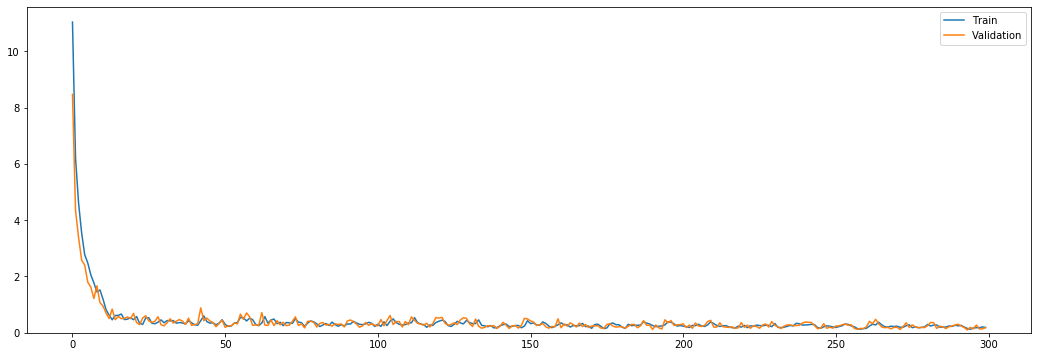

In [24]:
plot_loss(history)

In [25]:
y_pred = model.predict(X_val)

# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[0.41674984, 0.48822448, 0.6194189 , 0.6593575 , 0.74905205,
        0.83874667, 0.8786849 , 1.0098797 , 1.0935575 ],
       [0.8839208 , 1.0245795 , 1.2625309 , 1.3349688 , 1.4976507 ,
        1.6603327 , 1.73277   , 1.9707221 , 2.1087642 ]], dtype=float32)

## Employ pinball loss

In [26]:
# from Daniel Sch., at:
# https://stackoverflow.com/questions/43151694/define-pinball-loss-function-in-keras-with-tensorflow-backend
def create_pinball_loss(tau=0.5):
    def pinball_loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return pinball_loss

In [27]:
losses = {'q'+str(i): create_pinball_loss(tau=q) for (i, q) in enumerate(quantiles)}
losses

{'q0': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q1': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q2': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q3': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q4': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q5': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q6': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q7': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q8': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>}

### With dense layers

In [28]:
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [29]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

Train on 269 samples, validate on 68 samples
Epoch 1/300
269/269 [==============================] - 3s 11ms/sample - loss: 6.0870 - q0_loss: 0.1243 - q1_loss: 0.1216 - q2_loss: 0.4416 - q3_loss: 0.5545 - q4_loss: 0.3021 - q5_loss: 1.0783 - q6_loss: 1.0180 - q7_loss: 1.3783 - q8_loss: 0.9215 - val_loss: 4.8408 - val_q0_loss: 0.6611 - val_q1_loss: 0.6463 - val_q2_loss: 0.5951 - val_q3_loss: 0.7109 - val_q4_loss: 0.1732 - val_q5_loss: 1.3885 - val_q6_loss: 0.2031 - val_q7_loss: 0.3547 - val_q8_loss: 0.0836
Epoch 2/300
269/269 [==============================] - 0s 201us/sample - loss: 4.8809 - q0_loss: 0.2362 - q1_loss: 0.3836 - q2_loss: 0.6688 - q3_loss: 0.6148 - q4_loss: 0.3195 - q5_loss: 1.7370 - q6_loss: 0.1980 - q7_loss: 0.6089 - q8_loss: 0.0763 - val_loss: 3.8392 - val_q0_loss: 0.0250 - val_q1_loss: 0.1691 - val_q2_loss: 0.5256 - val_q3_loss: 0.4538 - val_q4_loss: 0.2306 - val_q5_loss: 1.4506 - val_q6_loss: 0.1710 - val_q7_loss: 0.6540 - val_q8_loss: 0.0740
Epoch 3/300
269/269 [=====

269/269 [==============================] - 0s 174us/sample - loss: 2.1784 - q0_loss: 0.0073 - q1_loss: 0.0039 - q2_loss: 0.3799 - q3_loss: 0.4456 - q4_loss: 0.0588 - q5_loss: 0.9394 - q6_loss: 0.0286 - q7_loss: 0.2925 - q8_loss: 0.0014 - val_loss: 1.9800 - val_q0_loss: 0.0215 - val_q1_loss: 0.0086 - val_q2_loss: 0.3363 - val_q3_loss: 0.4135 - val_q4_loss: 0.0598 - val_q5_loss: 0.7983 - val_q6_loss: 0.0317 - val_q7_loss: 0.1903 - val_q8_loss: 7.7102e-04
Epoch 19/300
269/269 [==============================] - 0s 174us/sample - loss: 2.1013 - q0_loss: 0.0048 - q1_loss: 0.0034 - q2_loss: 0.3829 - q3_loss: 0.4487 - q4_loss: 0.0455 - q5_loss: 0.9306 - q6_loss: 0.0290 - q7_loss: 0.2562 - q8_loss: 0.0013 - val_loss: 1.9105 - val_q0_loss: 0.0016 - val_q1_loss: 0.0019 - val_q2_loss: 0.3476 - val_q3_loss: 0.4016 - val_q4_loss: 0.0204 - val_q5_loss: 0.8152 - val_q6_loss: 0.0344 - val_q7_loss: 0.1629 - val_q8_loss: 0.0014
Epoch 20/300
269/269 [==============================] - 0s 174us/sample - los

269/269 [==============================] - 0s 174us/sample - loss: 1.3333 - q0_loss: 0.0010 - q1_loss: 0.0020 - q2_loss: 0.3052 - q3_loss: 0.3946 - q4_loss: 0.0467 - q5_loss: 0.5603 - q6_loss: 0.0124 - q7_loss: 0.0044 - q8_loss: 0.0127 - val_loss: 1.1957 - val_q0_loss: 6.3402e-04 - val_q1_loss: 0.0022 - val_q2_loss: 0.2676 - val_q3_loss: 0.3307 - val_q4_loss: 0.0282 - val_q5_loss: 0.4742 - val_q6_loss: 0.0082 - val_q7_loss: 0.0021 - val_q8_loss: 0.0011
Epoch 36/300
269/269 [==============================] - 0s 232us/sample - loss: 1.2942 - q0_loss: 9.7586e-04 - q1_loss: 0.0022 - q2_loss: 0.2999 - q3_loss: 0.3816 - q4_loss: 0.0381 - q5_loss: 0.5412 - q6_loss: 0.0135 - q7_loss: 0.0032 - q8_loss: 0.0089 - val_loss: 1.1339 - val_q0_loss: 5.5230e-04 - val_q1_loss: 0.0023 - val_q2_loss: 0.2536 - val_q3_loss: 0.3279 - val_q4_loss: 0.0141 - val_q5_loss: 0.4416 - val_q6_loss: 0.0069 - val_q7_loss: 0.0020 - val_q8_loss: 7.2717e-04
Epoch 37/300
269/269 [==============================] - 0s 174us/

269/269 [==============================] - 0s 174us/sample - loss: 0.7962 - q0_loss: 0.0051 - q1_loss: 0.0054 - q2_loss: 0.2210 - q3_loss: 0.3099 - q4_loss: 0.0189 - q5_loss: 0.2060 - q6_loss: 0.0146 - q7_loss: 0.0037 - q8_loss: 0.0012 - val_loss: 0.7360 - val_q0_loss: 3.4287e-04 - val_q1_loss: 0.0026 - val_q2_loss: 0.2008 - val_q3_loss: 0.2709 - val_q4_loss: 0.0444 - val_q5_loss: 0.1311 - val_q6_loss: 0.0152 - val_q7_loss: 0.0049 - val_q8_loss: 0.0014
Epoch 53/300
269/269 [==============================] - 0s 232us/sample - loss: 0.7759 - q0_loss: 0.0023 - q1_loss: 0.0016 - q2_loss: 0.2203 - q3_loss: 0.3132 - q4_loss: 0.0326 - q5_loss: 0.1793 - q6_loss: 0.0107 - q7_loss: 0.0038 - q8_loss: 0.0059 - val_loss: 0.6749 - val_q0_loss: 6.0921e-04 - val_q1_loss: 0.0018 - val_q2_loss: 0.1880 - val_q3_loss: 0.2518 - val_q4_loss: 0.0301 - val_q5_loss: 0.1331 - val_q6_loss: 0.0044 - val_q7_loss: 0.0031 - val_q8_loss: 9.9992e-04
Epoch 54/300
269/269 [==============================] - 0s 174us/samp

269/269 [==============================] - 0s 186us/sample - loss: 0.4890 - q0_loss: 9.2657e-04 - q1_loss: 0.0030 - q2_loss: 0.1542 - q3_loss: 0.2027 - q4_loss: 0.0192 - q5_loss: 0.0913 - q6_loss: 0.0142 - q7_loss: 0.0016 - q8_loss: 0.0014 - val_loss: 0.4243 - val_q0_loss: 0.0012 - val_q1_loss: 0.0035 - val_q2_loss: 0.1267 - val_q3_loss: 0.1483 - val_q4_loss: 0.0365 - val_q5_loss: 0.0500 - val_q6_loss: 0.0082 - val_q7_loss: 0.0011 - val_q8_loss: 0.0010
Epoch 70/300
269/269 [==============================] - 0s 159us/sample - loss: 0.4774 - q0_loss: 9.4716e-04 - q1_loss: 0.0029 - q2_loss: 0.1508 - q3_loss: 0.1965 - q4_loss: 0.0193 - q5_loss: 0.0895 - q6_loss: 0.0135 - q7_loss: 0.0017 - q8_loss: 0.0019 - val_loss: 0.4240 - val_q0_loss: 0.0012 - val_q1_loss: 0.0039 - val_q2_loss: 0.1213 - val_q3_loss: 0.1394 - val_q4_loss: 0.0309 - val_q5_loss: 0.0529 - val_q6_loss: 0.0187 - val_q7_loss: 0.0063 - val_q8_loss: 8.8448e-04
Epoch 71/300
269/269 [==============================] - 0s 174us/samp

269/269 [==============================] - 0s 174us/sample - loss: 0.3010 - q0_loss: 0.0011 - q1_loss: 0.0038 - q2_loss: 0.0945 - q3_loss: 0.1105 - q4_loss: 0.0215 - q5_loss: 0.0523 - q6_loss: 0.0182 - q7_loss: 0.0028 - q8_loss: 0.0015 - val_loss: 0.2551 - val_q0_loss: 0.0014 - val_q1_loss: 0.0048 - val_q2_loss: 0.0721 - val_q3_loss: 0.0553 - val_q4_loss: 0.0388 - val_q5_loss: 0.0302 - val_q6_loss: 0.0140 - val_q7_loss: 0.0022 - val_q8_loss: 0.0012
Epoch 87/300
269/269 [==============================] - 0s 174us/sample - loss: 0.2907 - q0_loss: 0.0019 - q1_loss: 0.0045 - q2_loss: 0.0900 - q3_loss: 0.1020 - q4_loss: 0.0297 - q5_loss: 0.0396 - q6_loss: 0.0197 - q7_loss: 0.0032 - q8_loss: 0.0018 - val_loss: 0.2313 - val_q0_loss: 0.0010 - val_q1_loss: 0.0040 - val_q2_loss: 0.0571 - val_q3_loss: 0.0731 - val_q4_loss: 0.0147 - val_q5_loss: 0.0342 - val_q6_loss: 0.0118 - val_q7_loss: 0.0024 - val_q8_loss: 6.9392e-04
Epoch 88/300
269/269 [==============================] - 0s 174us/sample - los

269/269 [==============================] - 0s 190us/sample - loss: 0.2010 - q0_loss: 0.0011 - q1_loss: 0.0038 - q2_loss: 0.0536 - q3_loss: 0.0769 - q4_loss: 0.0156 - q5_loss: 0.0324 - q6_loss: 0.0188 - q7_loss: 0.0032 - q8_loss: 0.0013 - val_loss: 0.1874 - val_q0_loss: 0.0015 - val_q1_loss: 0.0051 - val_q2_loss: 0.0310 - val_q3_loss: 0.0564 - val_q4_loss: 0.0179 - val_q5_loss: 0.0270 - val_q6_loss: 0.0218 - val_q7_loss: 0.0021 - val_q8_loss: 0.0011
Epoch 104/300
269/269 [==============================] - 0s 212us/sample - loss: 0.2449 - q0_loss: 0.0012 - q1_loss: 0.0040 - q2_loss: 0.0613 - q3_loss: 0.0857 - q4_loss: 0.0382 - q5_loss: 0.0317 - q6_loss: 0.0166 - q7_loss: 0.0030 - q8_loss: 0.0023 - val_loss: 0.2009 - val_q0_loss: 0.0014 - val_q1_loss: 0.0043 - val_q2_loss: 0.0346 - val_q3_loss: 0.0576 - val_q4_loss: 0.0406 - val_q5_loss: 0.0289 - val_q6_loss: 0.0119 - val_q7_loss: 0.0027 - val_q8_loss: 0.0015
Epoch 105/300
269/269 [==============================] - ETA: 0s - loss: 0.2486 

269/269 [==============================] - 0s 181us/sample - loss: 0.1959 - q0_loss: 0.0012 - q1_loss: 0.0035 - q2_loss: 0.0522 - q3_loss: 0.0753 - q4_loss: 0.0202 - q5_loss: 0.0288 - q6_loss: 0.0140 - q7_loss: 0.0029 - q8_loss: 0.0013 - val_loss: 0.1879 - val_q0_loss: 9.0088e-04 - val_q1_loss: 0.0030 - val_q2_loss: 0.0404 - val_q3_loss: 0.0457 - val_q4_loss: 0.0202 - val_q5_loss: 0.0448 - val_q6_loss: 0.0119 - val_q7_loss: 0.0033 - val_q8_loss: 8.5830e-04
Epoch 121/300
269/269 [==============================] - 0s 194us/sample - loss: 0.1888 - q0_loss: 0.0011 - q1_loss: 0.0032 - q2_loss: 0.0498 - q3_loss: 0.0662 - q4_loss: 0.0173 - q5_loss: 0.0313 - q6_loss: 0.0129 - q7_loss: 0.0028 - q8_loss: 0.0013 - val_loss: 0.1579 - val_q0_loss: 0.0013 - val_q1_loss: 0.0041 - val_q2_loss: 0.0286 - val_q3_loss: 0.0380 - val_q4_loss: 0.0126 - val_q5_loss: 0.0315 - val_q6_loss: 0.0203 - val_q7_loss: 0.0016 - val_q8_loss: 7.8298e-04
Epoch 122/300
269/269 [==============================] - 0s 191us/sa

269/269 [==============================] - 0s 174us/sample - loss: 0.1835 - q0_loss: 0.0011 - q1_loss: 0.0032 - q2_loss: 0.0492 - q3_loss: 0.0699 - q4_loss: 0.0165 - q5_loss: 0.0267 - q6_loss: 0.0131 - q7_loss: 0.0038 - q8_loss: 0.0012 - val_loss: 0.1594 - val_q0_loss: 0.0012 - val_q1_loss: 0.0031 - val_q2_loss: 0.0279 - val_q3_loss: 0.0374 - val_q4_loss: 0.0260 - val_q5_loss: 0.0311 - val_q6_loss: 0.0101 - val_q7_loss: 0.0024 - val_q8_loss: 0.0013
Epoch 138/300
269/269 [==============================] - 0s 216us/sample - loss: 0.1759 - q0_loss: 0.0011 - q1_loss: 0.0030 - q2_loss: 0.0484 - q3_loss: 0.0663 - q4_loss: 0.0173 - q5_loss: 0.0270 - q6_loss: 0.0106 - q7_loss: 0.0024 - q8_loss: 0.0013 - val_loss: 0.1472 - val_q0_loss: 0.0012 - val_q1_loss: 0.0033 - val_q2_loss: 0.0269 - val_q3_loss: 0.0383 - val_q4_loss: 0.0159 - val_q5_loss: 0.0312 - val_q6_loss: 0.0073 - val_q7_loss: 0.0020 - val_q8_loss: 0.0011
Epoch 139/300
269/269 [==============================] - 0s 174us/sample - loss:

269/269 [==============================] - 0s 271us/sample - loss: 0.1794 - q0_loss: 0.0012 - q1_loss: 0.0029 - q2_loss: 0.0516 - q3_loss: 0.0709 - q4_loss: 0.0221 - q5_loss: 0.0222 - q6_loss: 0.0091 - q7_loss: 0.0029 - q8_loss: 0.0015 - val_loss: 0.1643 - val_q0_loss: 0.0014 - val_q1_loss: 0.0037 - val_q2_loss: 0.0304 - val_q3_loss: 0.0525 - val_q4_loss: 0.0332 - val_q5_loss: 0.0190 - val_q6_loss: 0.0045 - val_q7_loss: 0.0015 - val_q8_loss: 0.0013
Epoch 155/300
269/269 [==============================] - 0s 190us/sample - loss: 0.1792 - q0_loss: 0.0012 - q1_loss: 0.0033 - q2_loss: 0.0470 - q3_loss: 0.0685 - q4_loss: 0.0252 - q5_loss: 0.0203 - q6_loss: 0.0064 - q7_loss: 0.0023 - q8_loss: 0.0014 - val_loss: 0.1844 - val_q0_loss: 8.7475e-04 - val_q1_loss: 0.0030 - val_q2_loss: 0.0429 - val_q3_loss: 0.0427 - val_q4_loss: 0.0399 - val_q5_loss: 0.0310 - val_q6_loss: 0.0047 - val_q7_loss: 0.0018 - val_q8_loss: 0.0030
Epoch 156/300
269/269 [==============================] - 0s 259us/sample - l

269/269 [==============================] - 0s 187us/sample - loss: 0.1483 - q0_loss: 0.0012 - q1_loss: 0.0033 - q2_loss: 0.0413 - q3_loss: 0.0567 - q4_loss: 0.0141 - q5_loss: 0.0164 - q6_loss: 0.0080 - q7_loss: 0.0026 - q8_loss: 0.0014 - val_loss: 0.1131 - val_q0_loss: 0.0012 - val_q1_loss: 0.0035 - val_q2_loss: 0.0240 - val_q3_loss: 0.0315 - val_q4_loss: 0.0099 - val_q5_loss: 0.0147 - val_q6_loss: 0.0049 - val_q7_loss: 0.0018 - val_q8_loss: 8.2421e-04
Epoch 172/300
269/269 [==============================] - 0s 216us/sample - loss: 0.1539 - q0_loss: 0.0012 - q1_loss: 0.0033 - q2_loss: 0.0434 - q3_loss: 0.0603 - q4_loss: 0.0174 - q5_loss: 0.0148 - q6_loss: 0.0098 - q7_loss: 0.0036 - q8_loss: 0.0014 - val_loss: 0.1316 - val_q0_loss: 0.0010 - val_q1_loss: 0.0033 - val_q2_loss: 0.0247 - val_q3_loss: 0.0345 - val_q4_loss: 0.0099 - val_q5_loss: 0.0249 - val_q6_loss: 0.0102 - val_q7_loss: 0.0028 - val_q8_loss: 9.9722e-04
Epoch 173/300
269/269 [==============================] - 0s 144us/sample

269/269 [==============================] - 0s 156us/sample - loss: 0.1428 - q0_loss: 0.0012 - q1_loss: 0.0032 - q2_loss: 0.0396 - q3_loss: 0.0539 - q4_loss: 0.0136 - q5_loss: 0.0162 - q6_loss: 0.0088 - q7_loss: 0.0044 - q8_loss: 0.0011 - val_loss: 0.1085 - val_q0_loss: 0.0012 - val_q1_loss: 0.0032 - val_q2_loss: 0.0216 - val_q3_loss: 0.0295 - val_q4_loss: 0.0119 - val_q5_loss: 0.0147 - val_q6_loss: 0.0055 - val_q7_loss: 0.0027 - val_q8_loss: 0.0010
Epoch 189/300
269/269 [==============================] - 0s 221us/sample - loss: 0.1424 - q0_loss: 0.0013 - q1_loss: 0.0033 - q2_loss: 0.0394 - q3_loss: 0.0523 - q4_loss: 0.0163 - q5_loss: 0.0140 - q6_loss: 0.0076 - q7_loss: 0.0033 - q8_loss: 0.0012 - val_loss: 0.1226 - val_q0_loss: 0.0015 - val_q1_loss: 0.0040 - val_q2_loss: 0.0258 - val_q3_loss: 0.0420 - val_q4_loss: 0.0177 - val_q5_loss: 0.0076 - val_q6_loss: 0.0051 - val_q7_loss: 0.0016 - val_q8_loss: 0.0011
Epoch 190/300
269/269 [==============================] - 0s 185us/sample - loss:

269/269 [==============================] - 0s 163us/sample - loss: 0.1118 - q0_loss: 0.0012 - q1_loss: 0.0034 - q2_loss: 0.0340 - q3_loss: 0.0476 - q4_loss: 0.0045 - q5_loss: 0.0101 - q6_loss: 0.0064 - q7_loss: 0.0042 - q8_loss: 0.0010 - val_loss: 0.0902 - val_q0_loss: 0.0012 - val_q1_loss: 0.0031 - val_q2_loss: 0.0195 - val_q3_loss: 0.0253 - val_q4_loss: 0.0054 - val_q5_loss: 0.0104 - val_q6_loss: 0.0055 - val_q7_loss: 0.0025 - val_q8_loss: 9.4425e-04
Epoch 206/300
269/269 [==============================] - 0s 219us/sample - loss: 0.1251 - q0_loss: 0.0014 - q1_loss: 0.0032 - q2_loss: 0.0376 - q3_loss: 0.0480 - q4_loss: 0.0075 - q5_loss: 0.0149 - q6_loss: 0.0080 - q7_loss: 0.0037 - q8_loss: 0.0011 - val_loss: 0.0871 - val_q0_loss: 0.0012 - val_q1_loss: 0.0031 - val_q2_loss: 0.0207 - val_q3_loss: 0.0256 - val_q4_loss: 0.0059 - val_q5_loss: 0.0086 - val_q6_loss: 0.0031 - val_q7_loss: 0.0021 - val_q8_loss: 7.8461e-04
Epoch 207/300
269/269 [==============================] - 0s 186us/sample

Epoch 222/300
269/269 [==============================] - 0s 174us/sample - loss: 0.0986 - q0_loss: 0.0012 - q1_loss: 0.0028 - q2_loss: 0.0322 - q3_loss: 0.0417 - q4_loss: 0.0050 - q5_loss: 0.0061 - q6_loss: 0.0036 - q7_loss: 0.0026 - q8_loss: 9.3193e-04 - val_loss: 0.0886 - val_q0_loss: 0.0012 - val_q1_loss: 0.0031 - val_q2_loss: 0.0220 - val_q3_loss: 0.0241 - val_q4_loss: 0.0099 - val_q5_loss: 0.0073 - val_q6_loss: 0.0031 - val_q7_loss: 0.0022 - val_q8_loss: 6.1098e-04
Epoch 223/300
269/269 [==============================] - 0s 174us/sample - loss: 0.1003 - q0_loss: 0.0013 - q1_loss: 0.0030 - q2_loss: 0.0314 - q3_loss: 0.0407 - q4_loss: 0.0056 - q5_loss: 0.0064 - q6_loss: 0.0041 - q7_loss: 0.0028 - q8_loss: 9.0149e-04 - val_loss: 0.0765 - val_q0_loss: 0.0012 - val_q1_loss: 0.0030 - val_q2_loss: 0.0193 - val_q3_loss: 0.0231 - val_q4_loss: 0.0046 - val_q5_loss: 0.0049 - val_q6_loss: 0.0025 - val_q7_loss: 0.0020 - val_q8_loss: 6.8924e-04
Epoch 224/300
269/269 [===========================

269/269 [==============================] - 0s 174us/sample - loss: 0.0975 - q0_loss: 0.0012 - q1_loss: 0.0025 - q2_loss: 0.0316 - q3_loss: 0.0378 - q4_loss: 0.0049 - q5_loss: 0.0089 - q6_loss: 0.0052 - q7_loss: 0.0032 - q8_loss: 9.6352e-04 - val_loss: 0.0701 - val_q0_loss: 0.0013 - val_q1_loss: 0.0030 - val_q2_loss: 0.0177 - val_q3_loss: 0.0208 - val_q4_loss: 0.0052 - val_q5_loss: 0.0039 - val_q6_loss: 0.0021 - val_q7_loss: 0.0018 - val_q8_loss: 7.0487e-04
Epoch 240/300
269/269 [==============================] - 0s 174us/sample - loss: 0.0891 - q0_loss: 0.0011 - q1_loss: 0.0027 - q2_loss: 0.0318 - q3_loss: 0.0392 - q4_loss: 0.0041 - q5_loss: 0.0059 - q6_loss: 0.0031 - q7_loss: 0.0026 - q8_loss: 9.4707e-04 - val_loss: 0.0754 - val_q0_loss: 0.0012 - val_q1_loss: 0.0029 - val_q2_loss: 0.0189 - val_q3_loss: 0.0207 - val_q4_loss: 0.0059 - val_q5_loss: 0.0062 - val_q6_loss: 0.0023 - val_q7_loss: 0.0020 - val_q8_loss: 6.8040e-04
Epoch 241/300
269/269 [==============================] - 0s 213u

269/269 [==============================] - 0s 167us/sample - loss: 0.0973 - q0_loss: 0.0012 - q1_loss: 0.0025 - q2_loss: 0.0294 - q3_loss: 0.0344 - q4_loss: 0.0150 - q5_loss: 0.0045 - q6_loss: 0.0055 - q7_loss: 0.0028 - q8_loss: 0.0013 - val_loss: 0.0859 - val_q0_loss: 0.0013 - val_q1_loss: 0.0025 - val_q2_loss: 0.0160 - val_q3_loss: 0.0219 - val_q4_loss: 0.0157 - val_q5_loss: 0.0053 - val_q6_loss: 0.0074 - val_q7_loss: 0.0026 - val_q8_loss: 0.0011
Epoch 257/300
269/269 [==============================] - 0s 174us/sample - loss: 0.1049 - q0_loss: 0.0011 - q1_loss: 0.0026 - q2_loss: 0.0286 - q3_loss: 0.0358 - q4_loss: 0.0153 - q5_loss: 0.0091 - q6_loss: 0.0082 - q7_loss: 0.0033 - q8_loss: 0.0012 - val_loss: 0.0783 - val_q0_loss: 0.0011 - val_q1_loss: 0.0022 - val_q2_loss: 0.0208 - val_q3_loss: 0.0187 - val_q4_loss: 0.0057 - val_q5_loss: 0.0087 - val_q6_loss: 0.0057 - val_q7_loss: 0.0025 - val_q8_loss: 8.1588e-04
Epoch 258/300
269/269 [==============================] - 0s 174us/sample - l

269/269 [==============================] - 0s 174us/sample - loss: 0.0925 - q0_loss: 0.0012 - q1_loss: 0.0024 - q2_loss: 0.0276 - q3_loss: 0.0305 - q4_loss: 0.0105 - q5_loss: 0.0084 - q6_loss: 0.0066 - q7_loss: 0.0034 - q8_loss: 0.0014 - val_loss: 0.0778 - val_q0_loss: 0.0014 - val_q1_loss: 0.0029 - val_q2_loss: 0.0153 - val_q3_loss: 0.0164 - val_q4_loss: 0.0067 - val_q5_loss: 0.0128 - val_q6_loss: 0.0075 - val_q7_loss: 0.0023 - val_q8_loss: 6.1433e-04
Epoch 274/300
269/269 [==============================] - 0s 232us/sample - loss: 0.0846 - q0_loss: 0.0012 - q1_loss: 0.0025 - q2_loss: 0.0251 - q3_loss: 0.0297 - q4_loss: 0.0086 - q5_loss: 0.0076 - q6_loss: 0.0055 - q7_loss: 0.0029 - q8_loss: 8.9354e-04 - val_loss: 0.0698 - val_q0_loss: 0.0013 - val_q1_loss: 0.0025 - val_q2_loss: 0.0141 - val_q3_loss: 0.0165 - val_q4_loss: 0.0065 - val_q5_loss: 0.0065 - val_q6_loss: 0.0047 - val_q7_loss: 0.0026 - val_q8_loss: 6.7590e-04
Epoch 275/300
269/269 [==============================] - 0s 174us/sa

269/269 [==============================] - 0s 204us/sample - loss: 0.0774 - q0_loss: 0.0011 - q1_loss: 0.0021 - q2_loss: 0.0248 - q3_loss: 0.0253 - q4_loss: 0.0059 - q5_loss: 0.0081 - q6_loss: 0.0058 - q7_loss: 0.0035 - q8_loss: 9.0002e-04 - val_loss: 0.0805 - val_q0_loss: 0.0012 - val_q1_loss: 0.0022 - val_q2_loss: 0.0178 - val_q3_loss: 0.0174 - val_q4_loss: 0.0095 - val_q5_loss: 0.0119 - val_q6_loss: 0.0088 - val_q7_loss: 0.0030 - val_q8_loss: 8.5000e-04
Epoch 291/300
269/269 [==============================] - 0s 197us/sample - loss: 0.0852 - q0_loss: 0.0013 - q1_loss: 0.0020 - q2_loss: 0.0260 - q3_loss: 0.0265 - q4_loss: 0.0108 - q5_loss: 0.0094 - q6_loss: 0.0067 - q7_loss: 0.0033 - q8_loss: 8.9804e-04 - val_loss: 0.0767 - val_q0_loss: 0.0014 - val_q1_loss: 0.0023 - val_q2_loss: 0.0164 - val_q3_loss: 0.0153 - val_q4_loss: 0.0172 - val_q5_loss: 0.0087 - val_q6_loss: 0.0051 - val_q7_loss: 0.0020 - val_q8_loss: 9.8870e-04
Epoch 292/300
269/269 [==============================] - 0s 193u

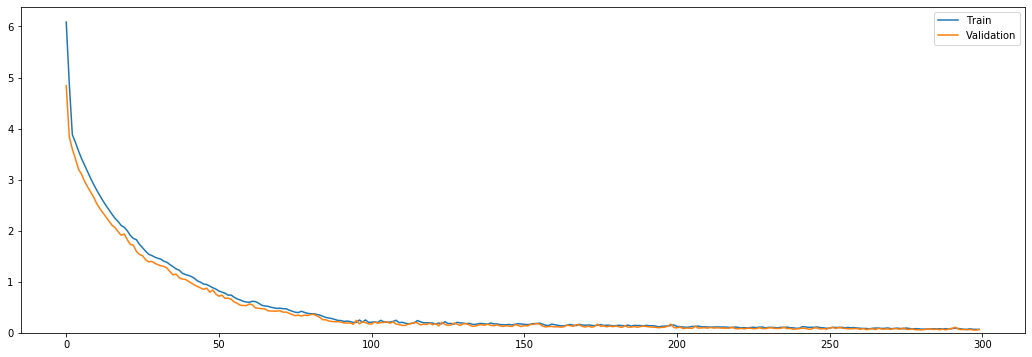

In [30]:
plot_loss(history)

In [31]:
# predict validation set
y_pred = model.predict(X_val)
# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[0.10605986, 0.3977252 , 0.61300826, 0.6536986 , 0.7306278 ,
        0.83061653, 0.8691999 , 1.0208597 , 1.1420536 ],
       [0.7934052 , 0.9982727 , 0.8821553 , 1.0920027 , 1.4962411 ,
        1.7172294 , 1.7722108 , 2.2575362 , 2.4568822 ]], dtype=float32)

### With distribution layer

In [32]:
model = get_dist_model(inp_shape=(train_df.columns.size,), sigma_coefs=sigma_coefs)
model.compile(optimizer="adam", loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [33]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

Train on 269 samples, validate on 68 samples
Epoch 1/300
269/269 [==============================] - 3s 13ms/sample - loss: 17.0815 - q0_loss: 0.7439 - q1_loss: 4.6247 - q2_loss: 3.4714 - q3_loss: 3.0795 - q4_loss: 2.1252 - q5_loss: 1.1411 - q6_loss: 0.7321 - q7_loss: 0.1100 - q8_loss: 0.1973 - val_loss: 4.2849 - val_q0_loss: 0.0244 - val_q1_loss: 0.1795 - val_q2_loss: 0.7177 - val_q3_loss: 0.9161 - val_q4_loss: 1.1102 - val_q5_loss: 0.6564 - val_q6_loss: 0.2561 - val_q7_loss: 0.0598 - val_q8_loss: 0.0311
Epoch 2/300
269/269 [==============================] - 0s 170us/sample - loss: 2.8703 - q0_loss: 0.0277 - q1_loss: 0.3034 - q2_loss: 0.5609 - q3_loss: 0.6293 - q4_loss: 0.6404 - q5_loss: 0.3954 - q6_loss: 0.2600 - q7_loss: 0.0716 - q8_loss: 0.0393 - val_loss: 2.5867 - val_q0_loss: 0.0307 - val_q1_loss: 0.4193 - val_q2_loss: 0.6027 - val_q3_loss: 0.6174 - val_q4_loss: 0.5379 - val_q5_loss: 0.3419 - val_q6_loss: 0.2501 - val_q7_loss: 0.0543 - val_q8_loss: 0.0353
Epoch 3/300
269/269 [====

269/269 [==============================] - 0s 208us/sample - loss: 0.4028 - q0_loss: 0.0326 - q1_loss: 0.0110 - q2_loss: 0.0392 - q3_loss: 0.0491 - q4_loss: 0.0719 - q5_loss: 0.0743 - q6_loss: 0.0657 - q7_loss: 0.0320 - q8_loss: 0.0269 - val_loss: 0.4507 - val_q0_loss: 0.0321 - val_q1_loss: 0.0154 - val_q2_loss: 0.0515 - val_q3_loss: 0.0649 - val_q4_loss: 0.0718 - val_q5_loss: 0.0668 - val_q6_loss: 0.0647 - val_q7_loss: 0.0502 - val_q8_loss: 0.0261
Epoch 19/300
269/269 [==============================] - 0s 193us/sample - loss: 0.4114 - q0_loss: 0.0321 - q1_loss: 0.0114 - q2_loss: 0.0358 - q3_loss: 0.0427 - q4_loss: 0.0715 - q5_loss: 0.0799 - q6_loss: 0.0714 - q7_loss: 0.0369 - q8_loss: 0.0267 - val_loss: 0.4008 - val_q0_loss: 0.0313 - val_q1_loss: 0.0206 - val_q2_loss: 0.0379 - val_q3_loss: 0.0432 - val_q4_loss: 0.0495 - val_q5_loss: 0.0609 - val_q6_loss: 0.0636 - val_q7_loss: 0.0599 - val_q8_loss: 0.0260
Epoch 20/300
269/269 [==============================] - 0s 202us/sample - loss: 0

Epoch 36/300
269/269 [==============================] - 0s 232us/sample - loss: 0.2270 - q0_loss: 0.0205 - q1_loss: 0.0082 - q2_loss: 0.0275 - q3_loss: 0.0322 - q4_loss: 0.0377 - q5_loss: 0.0367 - q6_loss: 0.0312 - q7_loss: 0.0117 - q8_loss: 0.0157 - val_loss: 0.1852 - val_q0_loss: 0.0195 - val_q1_loss: 0.0334 - val_q2_loss: 0.0293 - val_q3_loss: 0.0287 - val_q4_loss: 0.0265 - val_q5_loss: 0.0192 - val_q6_loss: 0.0150 - val_q7_loss: 0.0091 - val_q8_loss: 0.0164
Epoch 37/300
269/269 [==============================] - 0s 174us/sample - loss: 0.2309 - q0_loss: 0.0197 - q1_loss: 0.0166 - q2_loss: 0.0320 - q3_loss: 0.0358 - q4_loss: 0.0338 - q5_loss: 0.0331 - q6_loss: 0.0309 - q7_loss: 0.0164 - q8_loss: 0.0153 - val_loss: 0.1818 - val_q0_loss: 0.0192 - val_q1_loss: 0.0077 - val_q2_loss: 0.0231 - val_q3_loss: 0.0218 - val_q4_loss: 0.0203 - val_q5_loss: 0.0386 - val_q6_loss: 0.0342 - val_q7_loss: 0.0096 - val_q8_loss: 0.0152
Epoch 38/300
269/269 [==============================] - 0s 174us/sam

Epoch 54/300
269/269 [==============================] - ETA: 0s - loss: 0.1645 - q0_loss: 0.0142 - q1_loss: 0.0076 - q2_loss: 0.0307 - q3_loss: 0.0377 - q4_loss: 0.0361 - q5_loss: 0.0133 - q6_loss: 0.0113 - q7_loss: 0.0040 - q8_loss: 0.009 - 0s 128us/sample - loss: 0.1279 - q0_loss: 0.0140 - q1_loss: 0.0051 - q2_loss: 0.0153 - q3_loss: 0.0166 - q4_loss: 0.0182 - q5_loss: 0.0194 - q6_loss: 0.0172 - q7_loss: 0.0068 - q8_loss: 0.0104 - val_loss: 0.0902 - val_q0_loss: 0.0135 - val_q1_loss: 0.0024 - val_q2_loss: 0.0081 - val_q3_loss: 0.0099 - val_q4_loss: 0.0155 - val_q5_loss: 0.0140 - val_q6_loss: 0.0112 - val_q7_loss: 0.0030 - val_q8_loss: 0.0105
Epoch 55/300
269/269 [==============================] - 0s 174us/sample - loss: 0.1318 - q0_loss: 0.0142 - q1_loss: 0.0050 - q2_loss: 0.0160 - q3_loss: 0.0197 - q4_loss: 0.0239 - q5_loss: 0.0195 - q6_loss: 0.0163 - q7_loss: 0.0050 - q8_loss: 0.0100 - val_loss: 0.1344 - val_q0_loss: 0.0134 - val_q1_loss: 0.0042 - val_q2_loss: 0.0185 - val_q3_loss:

269/269 [==============================] - 0s 149us/sample - loss: 0.0905 - q0_loss: 0.0099 - q1_loss: 0.0030 - q2_loss: 0.0109 - q3_loss: 0.0138 - q4_loss: 0.0171 - q5_loss: 0.0128 - q6_loss: 0.0101 - q7_loss: 0.0032 - q8_loss: 0.0070 - val_loss: 0.0966 - val_q0_loss: 0.0093 - val_q1_loss: 0.0026 - val_q2_loss: 0.0117 - val_q3_loss: 0.0151 - val_q4_loss: 0.0191 - val_q5_loss: 0.0142 - val_q6_loss: 0.0096 - val_q7_loss: 0.0027 - val_q8_loss: 0.0069
Epoch 72/300
269/269 [==============================] - 0s 193us/sample - loss: 0.0820 - q0_loss: 0.0100 - q1_loss: 0.0032 - q2_loss: 0.0096 - q3_loss: 0.0114 - q4_loss: 0.0152 - q5_loss: 0.0136 - q6_loss: 0.0111 - q7_loss: 0.0030 - q8_loss: 0.0070 - val_loss: 0.0978 - val_q0_loss: 0.0095 - val_q1_loss: 0.0037 - val_q2_loss: 0.0102 - val_q3_loss: 0.0092 - val_q4_loss: 0.0125 - val_q5_loss: 0.0209 - val_q6_loss: 0.0182 - val_q7_loss: 0.0049 - val_q8_loss: 0.0076
Epoch 73/300
269/269 [==============================] - 0s 224us/sample - loss: 0

Epoch 89/300
269/269 [==============================] - 0s 203us/sample - loss: 0.0808 - q0_loss: 0.0069 - q1_loss: 0.0036 - q2_loss: 0.0111 - q3_loss: 0.0128 - q4_loss: 0.0131 - q5_loss: 0.0126 - q6_loss: 0.0109 - q7_loss: 0.0036 - q8_loss: 0.0043 - val_loss: 0.0532 - val_q0_loss: 0.0055 - val_q1_loss: 0.0012 - val_q2_loss: 0.0036 - val_q3_loss: 0.0059 - val_q4_loss: 0.0107 - val_q5_loss: 0.0099 - val_q6_loss: 0.0081 - val_q7_loss: 0.0021 - val_q8_loss: 0.0042
Epoch 90/300
269/269 [==============================] - 0s 193us/sample - loss: 0.0669 - q0_loss: 0.0067 - q1_loss: 0.0022 - q2_loss: 0.0071 - q3_loss: 0.0087 - q4_loss: 0.0114 - q5_loss: 0.0114 - q6_loss: 0.0103 - q7_loss: 0.0059 - q8_loss: 0.0042 - val_loss: 0.0917 - val_q0_loss: 0.0063 - val_q1_loss: 0.0019 - val_q2_loss: 0.0074 - val_q3_loss: 0.0108 - val_q4_loss: 0.0171 - val_q5_loss: 0.0176 - val_q6_loss: 0.0144 - val_q7_loss: 0.0036 - val_q8_loss: 0.0046
Epoch 91/300
269/269 [==============================] - 0s 187us/sam

Epoch 107/300
269/269 [==============================] - 0s 232us/sample - loss: 0.0691 - q0_loss: 0.0052 - q1_loss: 0.0041 - q2_loss: 0.0084 - q3_loss: 0.0095 - q4_loss: 0.0111 - q5_loss: 0.0128 - q6_loss: 0.0114 - q7_loss: 0.0051 - q8_loss: 0.0032 - val_loss: 0.0921 - val_q0_loss: 0.0045 - val_q1_loss: 0.0048 - val_q2_loss: 0.0165 - val_q3_loss: 0.0178 - val_q4_loss: 0.0087 - val_q5_loss: 0.0144 - val_q6_loss: 0.0143 - val_q7_loss: 0.0045 - val_q8_loss: 0.0037
Epoch 108/300
269/269 [==============================] - 0s 200us/sample - loss: 0.0839 - q0_loss: 0.0051 - q1_loss: 0.0040 - q2_loss: 0.0134 - q3_loss: 0.0163 - q4_loss: 0.0163 - q5_loss: 0.0126 - q6_loss: 0.0098 - q7_loss: 0.0029 - q8_loss: 0.0033 - val_loss: 0.0519 - val_q0_loss: 0.0043 - val_q1_loss: 0.0021 - val_q2_loss: 0.0088 - val_q3_loss: 0.0112 - val_q4_loss: 0.0122 - val_q5_loss: 0.0070 - val_q6_loss: 0.0053 - val_q7_loss: 0.0013 - val_q8_loss: 0.0028
Epoch 109/300
269/269 [==============================] - 0s 149us/

Epoch 125/300
269/269 [==============================] - 0s 186us/sample - loss: 0.0795 - q0_loss: 0.0047 - q1_loss: 0.0057 - q2_loss: 0.0126 - q3_loss: 0.0144 - q4_loss: 0.0140 - q5_loss: 0.0114 - q6_loss: 0.0093 - q7_loss: 0.0030 - q8_loss: 0.0028 - val_loss: 0.0573 - val_q0_loss: 0.0039 - val_q1_loss: 0.0019 - val_q2_loss: 0.0069 - val_q3_loss: 0.0083 - val_q4_loss: 0.0092 - val_q5_loss: 0.0104 - val_q6_loss: 0.0090 - val_q7_loss: 0.0024 - val_q8_loss: 0.0029
Epoch 126/300
269/269 [==============================] - 0s 179us/sample - loss: 0.0836 - q0_loss: 0.0047 - q1_loss: 0.0026 - q2_loss: 0.0107 - q3_loss: 0.0136 - q4_loss: 0.0171 - q5_loss: 0.0143 - q6_loss: 0.0119 - q7_loss: 0.0052 - q8_loss: 0.0031 - val_loss: 0.0662 - val_q0_loss: 0.0035 - val_q1_loss: 0.0013 - val_q2_loss: 0.0069 - val_q3_loss: 0.0101 - val_q4_loss: 0.0158 - val_q5_loss: 0.0138 - val_q6_loss: 0.0109 - val_q7_loss: 0.0026 - val_q8_loss: 0.0029
Epoch 127/300
269/269 [==============================] - 0s 190us/

Epoch 143/300
269/269 [==============================] - 0s 174us/sample - loss: 0.0776 - q0_loss: 0.0038 - q1_loss: 0.0037 - q2_loss: 0.0103 - q3_loss: 0.0120 - q4_loss: 0.0154 - q5_loss: 0.0141 - q6_loss: 0.0119 - q7_loss: 0.0036 - q8_loss: 0.0024 - val_loss: 0.2901 - val_q0_loss: 0.0028 - val_q1_loss: 0.0052 - val_q2_loss: 0.0106 - val_q3_loss: 0.0166 - val_q4_loss: 0.0349 - val_q5_loss: 0.0554 - val_q6_loss: 0.0630 - val_q7_loss: 0.0788 - val_q8_loss: 0.0014
Epoch 144/300
269/269 [==============================] - 0s 177us/sample - loss: 0.1676 - q0_loss: 0.0042 - q1_loss: 0.0060 - q2_loss: 0.0197 - q3_loss: 0.0223 - q4_loss: 0.0281 - q5_loss: 0.0335 - q6_loss: 0.0310 - q7_loss: 0.0155 - q8_loss: 0.0036 - val_loss: 0.0820 - val_q0_loss: 0.0027 - val_q1_loss: 0.0026 - val_q2_loss: 0.0099 - val_q3_loss: 0.0121 - val_q4_loss: 0.0191 - val_q5_loss: 0.0154 - val_q6_loss: 0.0118 - val_q7_loss: 0.0032 - val_q8_loss: 0.0029
Epoch 145/300
269/269 [==============================] - 0s 220us/

Epoch 161/300
269/269 [==============================] - 0s 174us/sample - loss: 0.1684 - q0_loss: 0.0047 - q1_loss: 0.0076 - q2_loss: 0.0207 - q3_loss: 0.0256 - q4_loss: 0.0373 - q5_loss: 0.0341 - q6_loss: 0.0280 - q7_loss: 0.0081 - q8_loss: 0.0033 - val_loss: 0.0942 - val_q0_loss: 0.0024 - val_q1_loss: 0.0031 - val_q2_loss: 0.0128 - val_q3_loss: 0.0156 - val_q4_loss: 0.0159 - val_q5_loss: 0.0132 - val_q6_loss: 0.0107 - val_q7_loss: 0.0018 - val_q8_loss: 0.0022
Epoch 162/300
269/269 [==============================] - 0s 174us/sample - loss: 0.0996 - q0_loss: 0.0041 - q1_loss: 0.0055 - q2_loss: 0.0156 - q3_loss: 0.0183 - q4_loss: 0.0204 - q5_loss: 0.0168 - q6_loss: 0.0138 - q7_loss: 0.0036 - q8_loss: 0.0031 - val_loss: 0.0704 - val_q0_loss: 0.0037 - val_q1_loss: 0.0033 - val_q2_loss: 0.0080 - val_q3_loss: 0.0098 - val_q4_loss: 0.0110 - val_q5_loss: 0.0103 - val_q6_loss: 0.0084 - val_q7_loss: 0.0033 - val_q8_loss: 0.0029
Epoch 163/300
269/269 [==============================] - 0s 174us/

Epoch 179/300
269/269 [==============================] - 0s 232us/sample - loss: 0.0955 - q0_loss: 0.0037 - q1_loss: 0.0037 - q2_loss: 0.0124 - q3_loss: 0.0157 - q4_loss: 0.0204 - q5_loss: 0.0188 - q6_loss: 0.0149 - q7_loss: 0.0044 - q8_loss: 0.0028 - val_loss: 0.0747 - val_q0_loss: 0.0027 - val_q1_loss: 0.0031 - val_q2_loss: 0.0112 - val_q3_loss: 0.0125 - val_q4_loss: 0.0101 - val_q5_loss: 0.0128 - val_q6_loss: 0.0110 - val_q7_loss: 0.0034 - val_q8_loss: 0.0025
Epoch 180/300
269/269 [==============================] - 0s 174us/sample - loss: 0.0790 - q0_loss: 0.0035 - q1_loss: 0.0037 - q2_loss: 0.0119 - q3_loss: 0.0143 - q4_loss: 0.0163 - q5_loss: 0.0134 - q6_loss: 0.0106 - q7_loss: 0.0026 - q8_loss: 0.0025 - val_loss: 0.0577 - val_q0_loss: 0.0026 - val_q1_loss: 0.0074 - val_q2_loss: 0.0107 - val_q3_loss: 0.0111 - val_q4_loss: 0.0110 - val_q5_loss: 0.0070 - val_q6_loss: 0.0052 - val_q7_loss: 0.0014 - val_q8_loss: 0.0022
Epoch 181/300
269/269 [==============================] - 0s 174us/

Epoch 197/300
269/269 [==============================] - 0s 197us/sample - loss: 0.0740 - q0_loss: 0.0029 - q1_loss: 0.0036 - q2_loss: 0.0103 - q3_loss: 0.0128 - q4_loss: 0.0149 - q5_loss: 0.0113 - q6_loss: 0.0101 - q7_loss: 0.0045 - q8_loss: 0.0022 - val_loss: 0.0611 - val_q0_loss: 0.0022 - val_q1_loss: 0.0040 - val_q2_loss: 0.0109 - val_q3_loss: 0.0131 - val_q4_loss: 0.0119 - val_q5_loss: 0.0079 - val_q6_loss: 0.0073 - val_q7_loss: 0.0022 - val_q8_loss: 0.0021
Epoch 198/300
269/269 [==============================] - 0s 193us/sample - loss: 0.0737 - q0_loss: 0.0032 - q1_loss: 0.0048 - q2_loss: 0.0111 - q3_loss: 0.0126 - q4_loss: 0.0126 - q5_loss: 0.0108 - q6_loss: 0.0099 - q7_loss: 0.0048 - q8_loss: 0.0024 - val_loss: 0.0711 - val_q0_loss: 0.0024 - val_q1_loss: 0.0152 - val_q2_loss: 0.0136 - val_q3_loss: 0.0133 - val_q4_loss: 0.0103 - val_q5_loss: 0.0059 - val_q6_loss: 0.0041 - val_q7_loss: 0.0025 - val_q8_loss: 0.0019
Epoch 199/300
269/269 [==============================] - 0s 197us/

Epoch 215/300
269/269 [==============================] - 0s 140us/sample - loss: 0.0889 - q0_loss: 0.0029 - q1_loss: 0.0035 - q2_loss: 0.0127 - q3_loss: 0.0155 - q4_loss: 0.0184 - q5_loss: 0.0163 - q6_loss: 0.0142 - q7_loss: 0.0039 - q8_loss: 0.0025 - val_loss: 0.0890 - val_q0_loss: 0.0024 - val_q1_loss: 0.0040 - val_q2_loss: 0.0155 - val_q3_loss: 0.0182 - val_q4_loss: 0.0156 - val_q5_loss: 0.0136 - val_q6_loss: 0.0124 - val_q7_loss: 0.0037 - val_q8_loss: 0.0023
Epoch 216/300
269/269 [==============================] - 0s 236us/sample - loss: 0.0883 - q0_loss: 0.0029 - q1_loss: 0.0039 - q2_loss: 0.0114 - q3_loss: 0.0142 - q4_loss: 0.0181 - q5_loss: 0.0169 - q6_loss: 0.0141 - q7_loss: 0.0039 - q8_loss: 0.0025 - val_loss: 0.1006 - val_q0_loss: 0.0033 - val_q1_loss: 0.0053 - val_q2_loss: 0.0222 - val_q3_loss: 0.0276 - val_q4_loss: 0.0285 - val_q5_loss: 0.0098 - val_q6_loss: 0.0054 - val_q7_loss: 0.0025 - val_q8_loss: 0.0026
Epoch 217/300
269/269 [==============================] - 0s 130us/

Epoch 233/300
269/269 [==============================] - 0s 190us/sample - loss: 0.0614 - q0_loss: 0.0034 - q1_loss: 0.0025 - q2_loss: 0.0083 - q3_loss: 0.0103 - q4_loss: 0.0116 - q5_loss: 0.0104 - q6_loss: 0.0088 - q7_loss: 0.0028 - q8_loss: 0.0026 - val_loss: 0.0823 - val_q0_loss: 0.0030 - val_q1_loss: 0.0031 - val_q2_loss: 0.0134 - val_q3_loss: 0.0168 - val_q4_loss: 0.0176 - val_q5_loss: 0.0107 - val_q6_loss: 0.0075 - val_q7_loss: 0.0017 - val_q8_loss: 0.0024
Epoch 234/300
269/269 [==============================] - 0s 193us/sample - loss: 0.0630 - q0_loss: 0.0030 - q1_loss: 0.0022 - q2_loss: 0.0080 - q3_loss: 0.0103 - q4_loss: 0.0130 - q5_loss: 0.0110 - q6_loss: 0.0091 - q7_loss: 0.0025 - q8_loss: 0.0023 - val_loss: 0.0774 - val_q0_loss: 0.0022 - val_q1_loss: 0.0015 - val_q2_loss: 0.0092 - val_q3_loss: 0.0136 - val_q4_loss: 0.0201 - val_q5_loss: 0.0166 - val_q6_loss: 0.0129 - val_q7_loss: 0.0029 - val_q8_loss: 0.0023
Epoch 235/300
269/269 [==============================] - 0s 179us/

Epoch 251/300
269/269 [==============================] - 0s 174us/sample - loss: 0.1708 - q0_loss: 0.0034 - q1_loss: 0.0108 - q2_loss: 0.0274 - q3_loss: 0.0310 - q4_loss: 0.0251 - q5_loss: 0.0285 - q6_loss: 0.0278 - q7_loss: 0.0158 - q8_loss: 0.0045 - val_loss: 0.1402 - val_q0_loss: 0.0037 - val_q1_loss: 0.0080 - val_q2_loss: 0.0194 - val_q3_loss: 0.0186 - val_q4_loss: 0.0128 - val_q5_loss: 0.0294 - val_q6_loss: 0.0271 - val_q7_loss: 0.0104 - val_q8_loss: 0.0043
Epoch 252/300
269/269 [==============================] - 0s 197us/sample - loss: 0.1121 - q0_loss: 0.0040 - q1_loss: 0.0064 - q2_loss: 0.0128 - q3_loss: 0.0141 - q4_loss: 0.0162 - q5_loss: 0.0210 - q6_loss: 0.0195 - q7_loss: 0.0124 - q8_loss: 0.0039 - val_loss: 0.0804 - val_q0_loss: 0.0042 - val_q1_loss: 0.0031 - val_q2_loss: 0.0084 - val_q3_loss: 0.0080 - val_q4_loss: 0.0137 - val_q5_loss: 0.0192 - val_q6_loss: 0.0165 - val_q7_loss: 0.0044 - val_q8_loss: 0.0042
Epoch 253/300
269/269 [==============================] - 0s 169us/

Epoch 269/300
269/269 [==============================] - 0s 193us/sample - loss: 0.1020 - q0_loss: 0.0030 - q1_loss: 0.0044 - q2_loss: 0.0151 - q3_loss: 0.0183 - q4_loss: 0.0191 - q5_loss: 0.0158 - q6_loss: 0.0147 - q7_loss: 0.0065 - q8_loss: 0.0029 - val_loss: 0.1045 - val_q0_loss: 0.0028 - val_q1_loss: 0.0045 - val_q2_loss: 0.0078 - val_q3_loss: 0.0097 - val_q4_loss: 0.0129 - val_q5_loss: 0.0172 - val_q6_loss: 0.0179 - val_q7_loss: 0.0186 - val_q8_loss: 0.0024
Epoch 270/300
269/269 [==============================] - 0s 191us/sample - loss: 0.0664 - q0_loss: 0.0030 - q1_loss: 0.0039 - q2_loss: 0.0087 - q3_loss: 0.0096 - q4_loss: 0.0096 - q5_loss: 0.0114 - q6_loss: 0.0104 - q7_loss: 0.0057 - q8_loss: 0.0028 - val_loss: 0.0622 - val_q0_loss: 0.0027 - val_q1_loss: 0.0024 - val_q2_loss: 0.0102 - val_q3_loss: 0.0127 - val_q4_loss: 0.0143 - val_q5_loss: 0.0073 - val_q6_loss: 0.0047 - val_q7_loss: 0.0013 - val_q8_loss: 0.0026
Epoch 271/300
269/269 [==============================] - 0s 185us/

Epoch 287/300
269/269 [==============================] - 0s 205us/sample - loss: 0.0897 - q0_loss: 0.0022 - q1_loss: 0.0078 - q2_loss: 0.0147 - q3_loss: 0.0159 - q4_loss: 0.0183 - q5_loss: 0.0125 - q6_loss: 0.0109 - q7_loss: 0.0048 - q8_loss: 0.0023 - val_loss: 0.0648 - val_q0_loss: 0.0023 - val_q1_loss: 0.0032 - val_q2_loss: 0.0101 - val_q3_loss: 0.0100 - val_q4_loss: 0.0054 - val_q5_loss: 0.0139 - val_q6_loss: 0.0127 - val_q7_loss: 0.0037 - val_q8_loss: 0.0026
Epoch 288/300
269/269 [==============================] - 0s 174us/sample - loss: 0.0918 - q0_loss: 0.0025 - q1_loss: 0.0032 - q2_loss: 0.0113 - q3_loss: 0.0148 - q4_loss: 0.0181 - q5_loss: 0.0167 - q6_loss: 0.0154 - q7_loss: 0.0077 - q8_loss: 0.0025 - val_loss: 0.0886 - val_q0_loss: 0.0027 - val_q1_loss: 0.0048 - val_q2_loss: 0.0195 - val_q3_loss: 0.0240 - val_q4_loss: 0.0225 - val_q5_loss: 0.0042 - val_q6_loss: 0.0047 - val_q7_loss: 0.0026 - val_q8_loss: 0.0026
Epoch 289/300
269/269 [==============================] - 0s 221us/

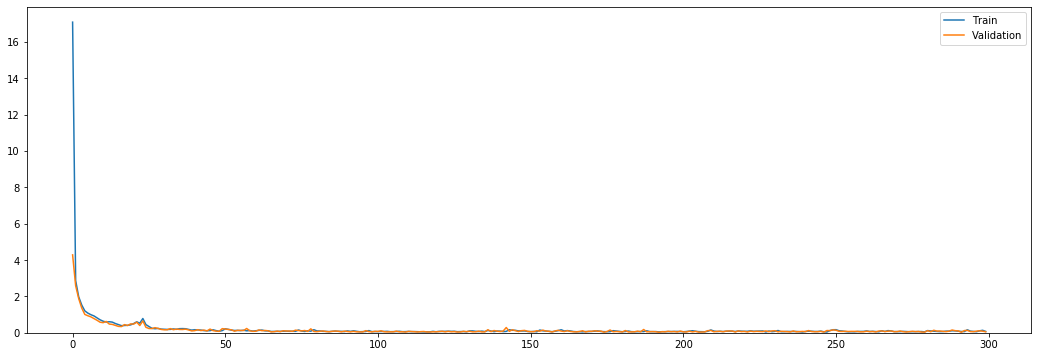

In [34]:
plot_loss(history)

In [35]:
# predict validation set
y_pred = model.predict(X_val)
# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[-0.18763965,  0.44276527,  0.58150333,  0.6237384 ,  0.7185904 ,
         0.81344235,  0.855677  ,  0.99441546,  1.6105204 ],
       [ 0.18763971,  0.91818315,  1.2134691 ,  1.3033609 ,  1.5052412 ,
         1.7071214 ,  1.7970123 ,  2.0922992 ,  2.7779238 ]],
      dtype=float32)

**Note**: the distribution of predictions is wider than when trained with the MAE. This is in line with what we would expect: over-predicting the lower quantiles is punished much harder than before, and the same for under-predicting the higher quantiles.

## Test pinball loss

In [36]:
# from https://github.com/keras-team/keras/pull/8033/files
def test_pinball_loss():
    y_pred = K.variable(np.array([0.3, 0.6, 0.1]))
    y_true = K.variable(np.array([0.3, 0.4, 0.5]))
    quantile = 0.25
    loss_fcn = create_pinball_loss(tau=quantile)#losses.PinballLoss(quantile)
    expected_loss = (quantile * 0.4 + (1 - quantile) * 0.2) / 3
    loss = K.eval(loss_fcn(y_true, y_pred))
    assert np.isclose(expected_loss, loss)

test_pinball_loss()

## Dataset 2

In [37]:
train_df = pd.read_csv("custom_layer/features2.csv", index_col=0)
target_df = pd.read_csv("custom_layer/targets2.csv", index_col=0, header=None, names=['target'])
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

In [38]:
train_df.head()

,wday,month,snap_CA,w_1,w_2,w_3,w_4,w_5,w_6,w_7
date,,,,,,,,,,
2011-01-29,1,1,0,1,0,0,0,0,0,0
2011-01-30,2,1,0,0,1,0,0,0,0,0
2011-01-31,3,1,0,0,0,1,0,0,0,0
2011-02-01,4,2,1,0,0,0,1,0,0,0
2011-02-02,5,2,1,0,0,0,0,1,0,0


In [39]:
target_df.head()

,target
2011-01-29,0.751272
2011-01-30,1.175314
2011-01-31,1.527411
2011-02-01,0.952662
2011-02-02,0.595021


In [40]:
# from Daniel Sch., at:
# https://stackoverflow.com/questions/43151694/define-pinball-loss-function-in-keras-with-tensorflow-backend
def create_pinball_loss(tau=0.5):
    def pinball_loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return pinball_loss

In [41]:
X = train_df.values
y = target_df.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_mo = {'q'+str(i): y_train for i in range(len(quantiles))}
y_val_mo = {'q'+str(i): y_val for i in range(len(quantiles))}

In [42]:
losses = {'q'+str(i): create_pinball_loss(tau=q) for (i, q) in enumerate(quantiles)}
losses

{'q0': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q1': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q2': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q3': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q4': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q5': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q6': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q7': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q8': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>}

### With dense layers

In [43]:
def get_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    
    out_q0 = Dense(1, name="q0")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q1 = Dense(1, name="q1")(x)  # DistributionLayer(quantile=quantiles[1])(x)
    out_q2 = Dense(1, name="q2")(x)  # ...
    out_q3 = Dense(1, name="q3")(x)
    out_q4 = Dense(1, name="q4")(x)
    out_q5 = Dense(1, name="q5")(x)
    out_q6 = Dense(1, name="q6")(x)
    out_q7 = Dense(1, name="q7")(x)
    out_q8 = Dense(1, name="q8")(x)

    model = Model(inputs=inp, outputs=[out_q0, out_q1, out_q2, out_q3, out_q4, out_q5, out_q6, out_q7, out_q8])

    return model

In [44]:
model = get_model(inp_shape=(X_train.shape[1],), quantiles=quantiles)
model.compile(optimizer="adam", loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [45]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

Train on 1575 samples, validate on 394 samples
Epoch 1/300
1575/1575 [==============================] - 4s 2ms/sample - loss: 4.0935 - q0_loss: 0.0121 - q1_loss: 0.2218 - q2_loss: 0.1299 - q3_loss: 0.1965 - q4_loss: 1.4940 - q5_loss: 0.5632 - q6_loss: 0.6119 - q7_loss: 0.4689 - q8_loss: 0.3687 - val_loss: 2.8738 - val_q0_loss: 0.0114 - val_q1_loss: 0.0875 - val_q2_loss: 0.0994 - val_q3_loss: 0.1345 - val_q4_loss: 1.2424 - val_q5_loss: 0.4862 - val_q6_loss: 0.2418 - val_q7_loss: 0.2360 - val_q8_loss: 0.3211
Epoch 2/300
1575/1575 [==============================] - 0s 139us/sample - loss: 2.5956 - q0_loss: 0.0105 - q1_loss: 0.0821 - q2_loss: 0.0952 - q3_loss: 0.1293 - q4_loss: 1.1490 - q5_loss: 0.4294 - q6_loss: 0.2052 - q7_loss: 0.2136 - q8_loss: 0.2867 - val_loss: 2.4078 - val_q0_loss: 0.0103 - val_q1_loss: 0.0792 - val_q2_loss: 0.0844 - val_q3_loss: 0.1226 - val_q4_loss: 1.0589 - val_q5_loss: 0.4430 - val_q6_loss: 0.1648 - val_q7_loss: 0.1993 - val_q8_loss: 0.2299
Epoch 3/300
1575/1575

1575/1575 [==============================] - 0s 132us/sample - loss: 0.3961 - q0_loss: 0.0040 - q1_loss: 0.0530 - q2_loss: 0.0488 - q3_loss: 0.0558 - q4_loss: 0.0996 - q5_loss: 0.0701 - q6_loss: 0.0506 - q7_loss: 0.0106 - q8_loss: 0.0038 - val_loss: 0.3941 - val_q0_loss: 0.0044 - val_q1_loss: 0.0531 - val_q2_loss: 0.0430 - val_q3_loss: 0.0519 - val_q4_loss: 0.1017 - val_q5_loss: 0.0690 - val_q6_loss: 0.0499 - val_q7_loss: 0.0113 - val_q8_loss: 0.0042
Epoch 19/300
1575/1575 [==============================] - 0s 124us/sample - loss: 0.3802 - q0_loss: 0.0039 - q1_loss: 0.0502 - q2_loss: 0.0459 - q3_loss: 0.0530 - q4_loss: 0.0960 - q5_loss: 0.0677 - q6_loss: 0.0484 - q7_loss: 0.0104 - q8_loss: 0.0037 - val_loss: 0.3857 - val_q0_loss: 0.0039 - val_q1_loss: 0.0516 - val_q2_loss: 0.0426 - val_q3_loss: 0.0513 - val_q4_loss: 0.0961 - val_q5_loss: 0.0694 - val_q6_loss: 0.0502 - val_q7_loss: 0.0119 - val_q8_loss: 0.0039
Epoch 20/300
1575/1575 [==============================] - 0s 124us/sample - l

Epoch 36/300
1575/1575 [==============================] - 0s 138us/sample - loss: 0.3095 - q0_loss: 0.0037 - q1_loss: 0.0144 - q2_loss: 0.0435 - q3_loss: 0.0536 - q4_loss: 0.0726 - q5_loss: 0.0597 - q6_loss: 0.0462 - q7_loss: 0.0107 - q8_loss: 0.0035 - val_loss: 0.3123 - val_q0_loss: 0.0035 - val_q1_loss: 0.0146 - val_q2_loss: 0.0423 - val_q3_loss: 0.0510 - val_q4_loss: 0.0719 - val_q5_loss: 0.0627 - val_q6_loss: 0.0469 - val_q7_loss: 0.0115 - val_q8_loss: 0.0032
Epoch 37/300
1575/1575 [==============================] - 0s 152us/sample - loss: 0.3034 - q0_loss: 0.0039 - q1_loss: 0.0138 - q2_loss: 0.0426 - q3_loss: 0.0531 - q4_loss: 0.0704 - q5_loss: 0.0587 - q6_loss: 0.0452 - q7_loss: 0.0107 - q8_loss: 0.0035 - val_loss: 0.3088 - val_q0_loss: 0.0036 - val_q1_loss: 0.0138 - val_q2_loss: 0.0428 - val_q3_loss: 0.0537 - val_q4_loss: 0.0698 - val_q5_loss: 0.0568 - val_q6_loss: 0.0493 - val_q7_loss: 0.0118 - val_q8_loss: 0.0037
Epoch 38/300
1575/1575 [==============================] - 0s 131

1575/1575 [==============================] - 0s 145us/sample - loss: 0.3020 - q0_loss: 0.0036 - q1_loss: 0.0123 - q2_loss: 0.0438 - q3_loss: 0.0546 - q4_loss: 0.0721 - q5_loss: 0.0565 - q6_loss: 0.0440 - q7_loss: 0.0107 - q8_loss: 0.0041 - val_loss: 0.3178 - val_q0_loss: 0.0035 - val_q1_loss: 0.0123 - val_q2_loss: 0.0404 - val_q3_loss: 0.0565 - val_q4_loss: 0.0684 - val_q5_loss: 0.0662 - val_q6_loss: 0.0506 - val_q7_loss: 0.0130 - val_q8_loss: 0.0040
Epoch 54/300
1575/1575 [==============================] - 0s 157us/sample - loss: 0.3137 - q0_loss: 0.0037 - q1_loss: 0.0125 - q2_loss: 0.0446 - q3_loss: 0.0561 - q4_loss: 0.0759 - q5_loss: 0.0609 - q6_loss: 0.0462 - q7_loss: 0.0114 - q8_loss: 0.0039 - val_loss: 0.3158 - val_q0_loss: 0.0034 - val_q1_loss: 0.0133 - val_q2_loss: 0.0459 - val_q3_loss: 0.0522 - val_q4_loss: 0.0778 - val_q5_loss: 0.0595 - val_q6_loss: 0.0444 - val_q7_loss: 0.0114 - val_q8_loss: 0.0035
Epoch 55/300
1575/1575 [==============================] - 0s 205us/sample - l

Epoch 71/300
1575/1575 [==============================] - 0s 260us/sample - loss: 0.2925 - q0_loss: 0.0033 - q1_loss: 0.0101 - q2_loss: 0.0415 - q3_loss: 0.0536 - q4_loss: 0.0685 - q5_loss: 0.0570 - q6_loss: 0.0435 - q7_loss: 0.0111 - q8_loss: 0.0034 - val_loss: 0.3031 - val_q0_loss: 0.0033 - val_q1_loss: 0.0098 - val_q2_loss: 0.0409 - val_q3_loss: 0.0541 - val_q4_loss: 0.0660 - val_q5_loss: 0.0602 - val_q6_loss: 0.0485 - val_q7_loss: 0.0122 - val_q8_loss: 0.0038
Epoch 72/300
1575/1575 [==============================] - 0s 295us/sample - loss: 0.2896 - q0_loss: 0.0033 - q1_loss: 0.0100 - q2_loss: 0.0417 - q3_loss: 0.0532 - q4_loss: 0.0676 - q5_loss: 0.0559 - q6_loss: 0.0431 - q7_loss: 0.0107 - q8_loss: 0.0035 - val_loss: 0.3022 - val_q0_loss: 0.0032 - val_q1_loss: 0.0099 - val_q2_loss: 0.0401 - val_q3_loss: 0.0544 - val_q4_loss: 0.0679 - val_q5_loss: 0.0606 - val_q6_loss: 0.0470 - val_q7_loss: 0.0122 - val_q8_loss: 0.0038
Epoch 73/300
1575/1575 [==============================] - 0s 281

1575/1575 [==============================] - 0s 212us/sample - loss: 0.2857 - q0_loss: 0.0031 - q1_loss: 0.0094 - q2_loss: 0.0414 - q3_loss: 0.0535 - q4_loss: 0.0673 - q5_loss: 0.0550 - q6_loss: 0.0428 - q7_loss: 0.0104 - q8_loss: 0.0033 - val_loss: 0.2863 - val_q0_loss: 0.0030 - val_q1_loss: 0.0092 - val_q2_loss: 0.0394 - val_q3_loss: 0.0510 - val_q4_loss: 0.0654 - val_q5_loss: 0.0561 - val_q6_loss: 0.0444 - val_q7_loss: 0.0109 - val_q8_loss: 0.0032
Epoch 89/300
1575/1575 [==============================] - 0s 250us/sample - loss: 0.2864 - q0_loss: 0.0031 - q1_loss: 0.0095 - q2_loss: 0.0414 - q3_loss: 0.0536 - q4_loss: 0.0679 - q5_loss: 0.0546 - q6_loss: 0.0426 - q7_loss: 0.0103 - q8_loss: 0.0033 - val_loss: 0.2970 - val_q0_loss: 0.0030 - val_q1_loss: 0.0096 - val_q2_loss: 0.0409 - val_q3_loss: 0.0526 - val_q4_loss: 0.0715 - val_q5_loss: 0.0570 - val_q6_loss: 0.0451 - val_q7_loss: 0.0107 - val_q8_loss: 0.0036
Epoch 90/300
1575/1575 [==============================] - 0s 207us/sample - l

1575/1575 [==============================] - 0s 316us/sample - loss: 0.2861 - q0_loss: 0.0029 - q1_loss: 0.0094 - q2_loss: 0.0411 - q3_loss: 0.0527 - q4_loss: 0.0679 - q5_loss: 0.0548 - q6_loss: 0.0428 - q7_loss: 0.0102 - q8_loss: 0.0032 - val_loss: 0.2939 - val_q0_loss: 0.0027 - val_q1_loss: 0.0097 - val_q2_loss: 0.0407 - val_q3_loss: 0.0511 - val_q4_loss: 0.0667 - val_q5_loss: 0.0592 - val_q6_loss: 0.0449 - val_q7_loss: 0.0114 - val_q8_loss: 0.0030
Epoch 106/300
1575/1575 [==============================] - 0s 259us/sample - loss: 0.2868 - q0_loss: 0.0028 - q1_loss: 0.0097 - q2_loss: 0.0415 - q3_loss: 0.0528 - q4_loss: 0.0679 - q5_loss: 0.0548 - q6_loss: 0.0426 - q7_loss: 0.0106 - q8_loss: 0.0032 - val_loss: 0.2869 - val_q0_loss: 0.0027 - val_q1_loss: 0.0094 - val_q2_loss: 0.0410 - val_q3_loss: 0.0518 - val_q4_loss: 0.0660 - val_q5_loss: 0.0545 - val_q6_loss: 0.0438 - val_q7_loss: 0.0108 - val_q8_loss: 0.0031
Epoch 107/300
1575/1575 [==============================] - 0s 280us/sample -

1575/1575 [==============================] - 0s 201us/sample - loss: 0.2852 - q0_loss: 0.0027 - q1_loss: 0.0092 - q2_loss: 0.0412 - q3_loss: 0.0534 - q4_loss: 0.0668 - q5_loss: 0.0548 - q6_loss: 0.0428 - q7_loss: 0.0104 - q8_loss: 0.0031 - val_loss: 0.2858 - val_q0_loss: 0.0025 - val_q1_loss: 0.0091 - val_q2_loss: 0.0396 - val_q3_loss: 0.0516 - val_q4_loss: 0.0676 - val_q5_loss: 0.0547 - val_q6_loss: 0.0438 - val_q7_loss: 0.0106 - val_q8_loss: 0.0030
Epoch 123/300
1575/1575 [==============================] - 0s 206us/sample - loss: 0.2843 - q0_loss: 0.0026 - q1_loss: 0.0095 - q2_loss: 0.0417 - q3_loss: 0.0538 - q4_loss: 0.0682 - q5_loss: 0.0538 - q6_loss: 0.0425 - q7_loss: 0.0103 - q8_loss: 0.0029 - val_loss: 0.2878 - val_q0_loss: 0.0025 - val_q1_loss: 0.0093 - val_q2_loss: 0.0402 - val_q3_loss: 0.0510 - val_q4_loss: 0.0661 - val_q5_loss: 0.0564 - val_q6_loss: 0.0442 - val_q7_loss: 0.0109 - val_q8_loss: 0.0028
Epoch 124/300
1575/1575 [==============================] - 0s 198us/sample -

1575/1575 [==============================] - 0s 181us/sample - loss: 0.2888 - q0_loss: 0.0025 - q1_loss: 0.0094 - q2_loss: 0.0415 - q3_loss: 0.0538 - q4_loss: 0.0682 - q5_loss: 0.0557 - q6_loss: 0.0431 - q7_loss: 0.0102 - q8_loss: 0.0028 - val_loss: 0.2929 - val_q0_loss: 0.0024 - val_q1_loss: 0.0090 - val_q2_loss: 0.0407 - val_q3_loss: 0.0527 - val_q4_loss: 0.0656 - val_q5_loss: 0.0576 - val_q6_loss: 0.0464 - val_q7_loss: 0.0123 - val_q8_loss: 0.0031
Epoch 140/300
1575/1575 [==============================] - ETA: 0s - loss: 0.2852 - q0_loss: 0.0025 - q1_loss: 0.0093 - q2_loss: 0.0414 - q3_loss: 0.0535 - q4_loss: 0.0678 - q5_loss: 0.0550 - q6_loss: 0.0430 - q7_loss: 0.0100 - q8_loss: 0.002 - 0s 182us/sample - loss: 0.2852 - q0_loss: 0.0025 - q1_loss: 0.0093 - q2_loss: 0.0415 - q3_loss: 0.0535 - q4_loss: 0.0677 - q5_loss: 0.0548 - q6_loss: 0.0429 - q7_loss: 0.0100 - q8_loss: 0.0027 - val_loss: 0.3078 - val_q0_loss: 0.0024 - val_q1_loss: 0.0091 - val_q2_loss: 0.0401 - val_q3_loss: 0.0523 

1575/1575 [==============================] - 0s 173us/sample - loss: 0.2824 - q0_loss: 0.0023 - q1_loss: 0.0095 - q2_loss: 0.0415 - q3_loss: 0.0535 - q4_loss: 0.0679 - q5_loss: 0.0534 - q6_loss: 0.0418 - q7_loss: 0.0099 - q8_loss: 0.0026 - val_loss: 0.2947 - val_q0_loss: 0.0024 - val_q1_loss: 0.0091 - val_q2_loss: 0.0411 - val_q3_loss: 0.0528 - val_q4_loss: 0.0658 - val_q5_loss: 0.0580 - val_q6_loss: 0.0464 - val_q7_loss: 0.0124 - val_q8_loss: 0.0029
Epoch 157/300
1575/1575 [==============================] - 0s 161us/sample - loss: 0.2851 - q0_loss: 0.0023 - q1_loss: 0.0093 - q2_loss: 0.0417 - q3_loss: 0.0540 - q4_loss: 0.0683 - q5_loss: 0.0559 - q6_loss: 0.0437 - q7_loss: 0.0109 - q8_loss: 0.0027 - val_loss: 0.2857 - val_q0_loss: 0.0023 - val_q1_loss: 0.0092 - val_q2_loss: 0.0407 - val_q3_loss: 0.0516 - val_q4_loss: 0.0663 - val_q5_loss: 0.0544 - val_q6_loss: 0.0435 - val_q7_loss: 0.0110 - val_q8_loss: 0.0026
Epoch 158/300
1575/1575 [==============================] - 0s 170us/sample -

1575/1575 [==============================] - 0s 272us/sample - loss: 0.2825 - q0_loss: 0.0024 - q1_loss: 0.0098 - q2_loss: 0.0423 - q3_loss: 0.0542 - q4_loss: 0.0680 - q5_loss: 0.0540 - q6_loss: 0.0422 - q7_loss: 0.0100 - q8_loss: 0.0026 - val_loss: 0.2846 - val_q0_loss: 0.0022 - val_q1_loss: 0.0090 - val_q2_loss: 0.0401 - val_q3_loss: 0.0516 - val_q4_loss: 0.0662 - val_q5_loss: 0.0546 - val_q6_loss: 0.0434 - val_q7_loss: 0.0112 - val_q8_loss: 0.0026
Epoch 174/300
1575/1575 [==============================] - 0s 244us/sample - loss: 0.2848 - q0_loss: 0.0023 - q1_loss: 0.0093 - q2_loss: 0.0415 - q3_loss: 0.0536 - q4_loss: 0.0678 - q5_loss: 0.0544 - q6_loss: 0.0424 - q7_loss: 0.0103 - q8_loss: 0.0026 - val_loss: 0.2845 - val_q0_loss: 0.0023 - val_q1_loss: 0.0091 - val_q2_loss: 0.0405 - val_q3_loss: 0.0517 - val_q4_loss: 0.0654 - val_q5_loss: 0.0545 - val_q6_loss: 0.0439 - val_q7_loss: 0.0109 - val_q8_loss: 0.0024
Epoch 175/300
1575/1575 [==============================] - 0s 277us/sample -

1575/1575 [==============================] - 0s 201us/sample - loss: 0.2805 - q0_loss: 0.0024 - q1_loss: 0.0094 - q2_loss: 0.0414 - q3_loss: 0.0535 - q4_loss: 0.0672 - q5_loss: 0.0536 - q6_loss: 0.0418 - q7_loss: 0.0099 - q8_loss: 0.0025 - val_loss: 0.2856 - val_q0_loss: 0.0022 - val_q1_loss: 0.0090 - val_q2_loss: 0.0400 - val_q3_loss: 0.0513 - val_q4_loss: 0.0652 - val_q5_loss: 0.0557 - val_q6_loss: 0.0444 - val_q7_loss: 0.0111 - val_q8_loss: 0.0026
Epoch 191/300
1575/1575 [==============================] - 0s 234us/sample - loss: 0.2847 - q0_loss: 0.0023 - q1_loss: 0.0095 - q2_loss: 0.0415 - q3_loss: 0.0535 - q4_loss: 0.0676 - q5_loss: 0.0545 - q6_loss: 0.0429 - q7_loss: 0.0104 - q8_loss: 0.0025 - val_loss: 0.2839 - val_q0_loss: 0.0022 - val_q1_loss: 0.0090 - val_q2_loss: 0.0398 - val_q3_loss: 0.0518 - val_q4_loss: 0.0656 - val_q5_loss: 0.0546 - val_q6_loss: 0.0430 - val_q7_loss: 0.0112 - val_q8_loss: 0.0026
Epoch 192/300
1575/1575 [==============================] - 0s 211us/sample -

1575/1575 [==============================] - 0s 169us/sample - loss: 0.2810 - q0_loss: 0.0024 - q1_loss: 0.0092 - q2_loss: 0.0409 - q3_loss: 0.0527 - q4_loss: 0.0662 - q5_loss: 0.0540 - q6_loss: 0.0421 - q7_loss: 0.0104 - q8_loss: 0.0025 - val_loss: 0.2848 - val_q0_loss: 0.0023 - val_q1_loss: 0.0090 - val_q2_loss: 0.0399 - val_q3_loss: 0.0518 - val_q4_loss: 0.0658 - val_q5_loss: 0.0548 - val_q6_loss: 0.0430 - val_q7_loss: 0.0113 - val_q8_loss: 0.0027
Epoch 208/300
1575/1575 [==============================] - 0s 190us/sample - loss: 0.2806 - q0_loss: 0.0024 - q1_loss: 0.0094 - q2_loss: 0.0414 - q3_loss: 0.0529 - q4_loss: 0.0667 - q5_loss: 0.0529 - q6_loss: 0.0417 - q7_loss: 0.0100 - q8_loss: 0.0024 - val_loss: 0.2842 - val_q0_loss: 0.0022 - val_q1_loss: 0.0091 - val_q2_loss: 0.0400 - val_q3_loss: 0.0514 - val_q4_loss: 0.0662 - val_q5_loss: 0.0546 - val_q6_loss: 0.0437 - val_q7_loss: 0.0107 - val_q8_loss: 0.0027
Epoch 209/300
1575/1575 [==============================] - 0s 200us/sample -

1575/1575 [==============================] - 0s 179us/sample - loss: 0.2836 - q0_loss: 0.0024 - q1_loss: 0.0094 - q2_loss: 0.0416 - q3_loss: 0.0536 - q4_loss: 0.0678 - q5_loss: 0.0540 - q6_loss: 0.0427 - q7_loss: 0.0103 - q8_loss: 0.0027 - val_loss: 0.2822 - val_q0_loss: 0.0023 - val_q1_loss: 0.0089 - val_q2_loss: 0.0398 - val_q3_loss: 0.0513 - val_q4_loss: 0.0652 - val_q5_loss: 0.0541 - val_q6_loss: 0.0434 - val_q7_loss: 0.0109 - val_q8_loss: 0.0026
Epoch 225/300
1575/1575 [==============================] - 0s 215us/sample - loss: 0.2825 - q0_loss: 0.0023 - q1_loss: 0.0095 - q2_loss: 0.0413 - q3_loss: 0.0530 - q4_loss: 0.0662 - q5_loss: 0.0536 - q6_loss: 0.0420 - q7_loss: 0.0100 - q8_loss: 0.0025 - val_loss: 0.2858 - val_q0_loss: 0.0022 - val_q1_loss: 0.0092 - val_q2_loss: 0.0404 - val_q3_loss: 0.0518 - val_q4_loss: 0.0659 - val_q5_loss: 0.0553 - val_q6_loss: 0.0445 - val_q7_loss: 0.0108 - val_q8_loss: 0.0026
Epoch 226/300
1575/1575 [==============================] - 0s 291us/sample -

1575/1575 [==============================] - 0s 169us/sample - loss: 0.2801 - q0_loss: 0.0023 - q1_loss: 0.0093 - q2_loss: 0.0416 - q3_loss: 0.0536 - q4_loss: 0.0673 - q5_loss: 0.0535 - q6_loss: 0.0419 - q7_loss: 0.0099 - q8_loss: 0.0025 - val_loss: 0.2858 - val_q0_loss: 0.0022 - val_q1_loss: 0.0092 - val_q2_loss: 0.0403 - val_q3_loss: 0.0515 - val_q4_loss: 0.0659 - val_q5_loss: 0.0548 - val_q6_loss: 0.0440 - val_q7_loss: 0.0110 - val_q8_loss: 0.0027
Epoch 242/300
1575/1575 [==============================] - 0s 175us/sample - loss: 0.2831 - q0_loss: 0.0025 - q1_loss: 0.0096 - q2_loss: 0.0419 - q3_loss: 0.0542 - q4_loss: 0.0675 - q5_loss: 0.0539 - q6_loss: 0.0420 - q7_loss: 0.0100 - q8_loss: 0.0024 - val_loss: 0.2856 - val_q0_loss: 0.0022 - val_q1_loss: 0.0092 - val_q2_loss: 0.0402 - val_q3_loss: 0.0520 - val_q4_loss: 0.0667 - val_q5_loss: 0.0546 - val_q6_loss: 0.0431 - val_q7_loss: 0.0108 - val_q8_loss: 0.0029
Epoch 243/300
1575/1575 [==============================] - 0s 160us/sample -

1575/1575 [==============================] - 0s 174us/sample - loss: 0.2821 - q0_loss: 0.0023 - q1_loss: 0.0096 - q2_loss: 0.0415 - q3_loss: 0.0535 - q4_loss: 0.0667 - q5_loss: 0.0535 - q6_loss: 0.0419 - q7_loss: 0.0099 - q8_loss: 0.0026 - val_loss: 0.2831 - val_q0_loss: 0.0022 - val_q1_loss: 0.0089 - val_q2_loss: 0.0396 - val_q3_loss: 0.0513 - val_q4_loss: 0.0660 - val_q5_loss: 0.0547 - val_q6_loss: 0.0443 - val_q7_loss: 0.0108 - val_q8_loss: 0.0025
Epoch 259/300
1575/1575 [==============================] - 0s 159us/sample - loss: 0.2806 - q0_loss: 0.0023 - q1_loss: 0.0094 - q2_loss: 0.0412 - q3_loss: 0.0531 - q4_loss: 0.0671 - q5_loss: 0.0537 - q6_loss: 0.0422 - q7_loss: 0.0102 - q8_loss: 0.0025 - val_loss: 0.2819 - val_q0_loss: 0.0022 - val_q1_loss: 0.0090 - val_q2_loss: 0.0397 - val_q3_loss: 0.0512 - val_q4_loss: 0.0649 - val_q5_loss: 0.0544 - val_q6_loss: 0.0435 - val_q7_loss: 0.0107 - val_q8_loss: 0.0025
Epoch 260/300
1575/1575 [==============================] - 0s 168us/sample -

1575/1575 [==============================] - 0s 182us/sample - loss: 0.2814 - q0_loss: 0.0023 - q1_loss: 0.0094 - q2_loss: 0.0414 - q3_loss: 0.0531 - q4_loss: 0.0669 - q5_loss: 0.0536 - q6_loss: 0.0417 - q7_loss: 0.0098 - q8_loss: 0.0024 - val_loss: 0.2857 - val_q0_loss: 0.0021 - val_q1_loss: 0.0091 - val_q2_loss: 0.0397 - val_q3_loss: 0.0513 - val_q4_loss: 0.0655 - val_q5_loss: 0.0565 - val_q6_loss: 0.0445 - val_q7_loss: 0.0108 - val_q8_loss: 0.0026
Epoch 276/300
1575/1575 [==============================] - 0s 176us/sample - loss: 0.2808 - q0_loss: 0.0023 - q1_loss: 0.0092 - q2_loss: 0.0411 - q3_loss: 0.0530 - q4_loss: 0.0668 - q5_loss: 0.0534 - q6_loss: 0.0419 - q7_loss: 0.0101 - q8_loss: 0.0025 - val_loss: 0.2893 - val_q0_loss: 0.0023 - val_q1_loss: 0.0090 - val_q2_loss: 0.0408 - val_q3_loss: 0.0525 - val_q4_loss: 0.0655 - val_q5_loss: 0.0558 - val_q6_loss: 0.0450 - val_q7_loss: 0.0118 - val_q8_loss: 0.0026
Epoch 277/300
1575/1575 [==============================] - 0s 179us/sample -

1575/1575 [==============================] - 0s 156us/sample - loss: 0.2812 - q0_loss: 0.0023 - q1_loss: 0.0095 - q2_loss: 0.0414 - q3_loss: 0.0530 - q4_loss: 0.0662 - q5_loss: 0.0530 - q6_loss: 0.0416 - q7_loss: 0.0100 - q8_loss: 0.0024 - val_loss: 0.2897 - val_q0_loss: 0.0022 - val_q1_loss: 0.0089 - val_q2_loss: 0.0408 - val_q3_loss: 0.0520 - val_q4_loss: 0.0655 - val_q5_loss: 0.0568 - val_q6_loss: 0.0460 - val_q7_loss: 0.0114 - val_q8_loss: 0.0028
Epoch 293/300
1575/1575 [==============================] - 0s 172us/sample - loss: 0.2811 - q0_loss: 0.0023 - q1_loss: 0.0093 - q2_loss: 0.0410 - q3_loss: 0.0530 - q4_loss: 0.0664 - q5_loss: 0.0536 - q6_loss: 0.0420 - q7_loss: 0.0101 - q8_loss: 0.0024 - val_loss: 0.2829 - val_q0_loss: 0.0022 - val_q1_loss: 0.0089 - val_q2_loss: 0.0397 - val_q3_loss: 0.0511 - val_q4_loss: 0.0652 - val_q5_loss: 0.0551 - val_q6_loss: 0.0444 - val_q7_loss: 0.0107 - val_q8_loss: 0.0025
Epoch 294/300
1575/1575 [==============================] - 0s 170us/sample -

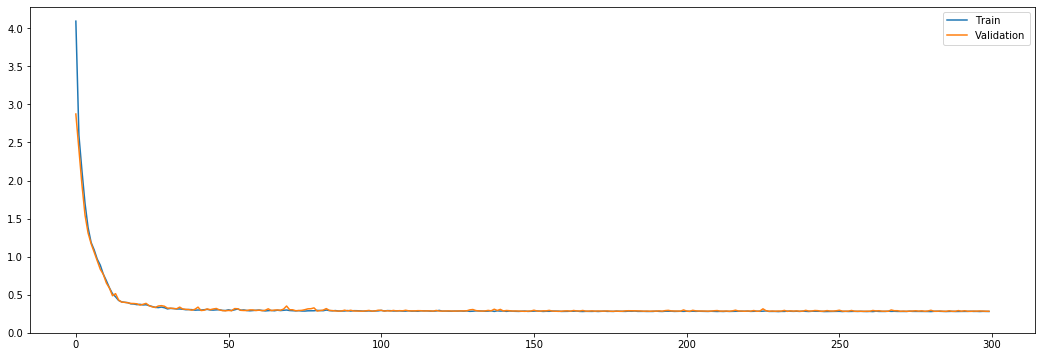

In [46]:
plot_loss(history)

**Predicted distribution**

In [47]:
# predict validation set
y_pred = model.predict(X_val)
# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[0.39618376, 0.4977876 , 0.6054545 , 0.64978516, 0.734853  ,
        0.8303664 , 0.8647891 , 0.9975567 , 1.083015  ],
       [0.8308075 , 0.9606819 , 1.1836642 , 1.2716727 , 1.4321975 ,
        1.62726   , 1.7035255 , 1.9478652 , 2.1222374 ]], dtype=float32)

### With distribution layer

In [48]:
model = get_dist_model(inp_shape=(X_train.shape[1],), sigma_coefs=sigma_coefs)
model.compile(optimizer="adam", loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [49]:
history_dist = model.fit(X_train, y_train_mo, epochs=300,
                         validation_data=(X_val, y_val_mo))

Train on 1575 samples, validate on 394 samples
Epoch 1/300
1575/1575 [==============================] - 6s 4ms/sample - loss: 4.6934 - q0_loss: 0.1597 - q1_loss: 0.6277 - q2_loss: 0.7688 - q3_loss: 0.8122 - q4_loss: 0.7961 - q5_loss: 0.5923 - q6_loss: 0.4919 - q7_loss: 0.3325 - q8_loss: 0.0537 - val_loss: 1.0685 - val_q0_loss: 0.0088 - val_q1_loss: 0.0459 - val_q2_loss: 0.1757 - val_q3_loss: 0.2192 - val_q4_loss: 0.2445 - val_q5_loss: 0.1739 - val_q6_loss: 0.1354 - val_q7_loss: 0.0436 - val_q8_loss: 0.0156
Epoch 2/300
1575/1575 [==============================] - 0s 246us/sample - loss: 0.7932 - q0_loss: 0.0087 - q1_loss: 0.0284 - q2_loss: 0.1094 - q3_loss: 0.1383 - q4_loss: 0.1773 - q5_loss: 0.1565 - q6_loss: 0.1265 - q7_loss: 0.0362 - q8_loss: 0.0121 - val_loss: 0.6313 - val_q0_loss: 0.0073 - val_q1_loss: 0.0193 - val_q2_loss: 0.0784 - val_q3_loss: 0.1008 - val_q4_loss: 0.1464 - val_q5_loss: 0.1275 - val_q6_loss: 0.1027 - val_q7_loss: 0.0283 - val_q8_loss: 0.0095
Epoch 3/300
1575/1575

1575/1575 [==============================] - 0s 162us/sample - loss: 0.3034 - q0_loss: 0.0045 - q1_loss: 0.0115 - q2_loss: 0.0446 - q3_loss: 0.0562 - q4_loss: 0.0706 - q5_loss: 0.0571 - q6_loss: 0.0452 - q7_loss: 0.0116 - q8_loss: 0.0037 - val_loss: 0.3113 - val_q0_loss: 0.0053 - val_q1_loss: 0.0101 - val_q2_loss: 0.0427 - val_q3_loss: 0.0544 - val_q4_loss: 0.0709 - val_q5_loss: 0.0598 - val_q6_loss: 0.0480 - val_q7_loss: 0.0121 - val_q8_loss: 0.0039
Epoch 19/300
1575/1575 [==============================] - 0s 185us/sample - loss: 0.3205 - q0_loss: 0.0046 - q1_loss: 0.0111 - q2_loss: 0.0469 - q3_loss: 0.0600 - q4_loss: 0.0743 - q5_loss: 0.0595 - q6_loss: 0.0466 - q7_loss: 0.0119 - q8_loss: 0.0037 - val_loss: 0.3158 - val_q0_loss: 0.0060 - val_q1_loss: 0.0103 - val_q2_loss: 0.0430 - val_q3_loss: 0.0550 - val_q4_loss: 0.0718 - val_q5_loss: 0.0610 - val_q6_loss: 0.0486 - val_q7_loss: 0.0122 - val_q8_loss: 0.0045
Epoch 20/300
1575/1575 [==============================] - 0s 198us/sample - l

Epoch 36/300
1575/1575 [==============================] - 0s 225us/sample - loss: 0.2973 - q0_loss: 0.0035 - q1_loss: 0.0105 - q2_loss: 0.0435 - q3_loss: 0.0558 - q4_loss: 0.0691 - q5_loss: 0.0559 - q6_loss: 0.0443 - q7_loss: 0.0111 - q8_loss: 0.0033 - val_loss: 0.3045 - val_q0_loss: 0.0040 - val_q1_loss: 0.0092 - val_q2_loss: 0.0404 - val_q3_loss: 0.0529 - val_q4_loss: 0.0714 - val_q5_loss: 0.0588 - val_q6_loss: 0.0473 - val_q7_loss: 0.0120 - val_q8_loss: 0.0040
Epoch 37/300
1575/1575 [==============================] - 0s 219us/sample - loss: 0.3031 - q0_loss: 0.0037 - q1_loss: 0.0111 - q2_loss: 0.0452 - q3_loss: 0.0574 - q4_loss: 0.0709 - q5_loss: 0.0568 - q6_loss: 0.0447 - q7_loss: 0.0115 - q8_loss: 0.0035 - val_loss: 0.4545 - val_q0_loss: 0.0040 - val_q1_loss: 0.0579 - val_q2_loss: 0.0856 - val_q3_loss: 0.0913 - val_q4_loss: 0.0881 - val_q5_loss: 0.0630 - val_q6_loss: 0.0484 - val_q7_loss: 0.0133 - val_q8_loss: 0.0055
Epoch 38/300
1575/1575 [==============================] - 0s 274

1575/1575 [==============================] - 0s 162us/sample - loss: 0.3013 - q0_loss: 0.0035 - q1_loss: 0.0110 - q2_loss: 0.0440 - q3_loss: 0.0555 - q4_loss: 0.0697 - q5_loss: 0.0565 - q6_loss: 0.0453 - q7_loss: 0.0121 - q8_loss: 0.0037 - val_loss: 0.3416 - val_q0_loss: 0.0054 - val_q1_loss: 0.0133 - val_q2_loss: 0.0452 - val_q3_loss: 0.0538 - val_q4_loss: 0.0709 - val_q5_loss: 0.0696 - val_q6_loss: 0.0592 - val_q7_loss: 0.0160 - val_q8_loss: 0.0061
Epoch 54/300
1575/1575 [==============================] - 0s 187us/sample - loss: 0.3101 - q0_loss: 0.0037 - q1_loss: 0.0114 - q2_loss: 0.0442 - q3_loss: 0.0564 - q4_loss: 0.0707 - q5_loss: 0.0588 - q6_loss: 0.0476 - q7_loss: 0.0134 - q8_loss: 0.0035 - val_loss: 0.2991 - val_q0_loss: 0.0027 - val_q1_loss: 0.0123 - val_q2_loss: 0.0436 - val_q3_loss: 0.0541 - val_q4_loss: 0.0660 - val_q5_loss: 0.0545 - val_q6_loss: 0.0443 - val_q7_loss: 0.0139 - val_q8_loss: 0.0030
Epoch 55/300
1575/1575 [==============================] - 0s 167us/sample - l

Epoch 71/300
1575/1575 [==============================] - 0s 201us/sample - loss: 0.2918 - q0_loss: 0.0034 - q1_loss: 0.0107 - q2_loss: 0.0430 - q3_loss: 0.0549 - q4_loss: 0.0678 - q5_loss: 0.0539 - q6_loss: 0.0428 - q7_loss: 0.0109 - q8_loss: 0.0036 - val_loss: 0.3069 - val_q0_loss: 0.0024 - val_q1_loss: 0.0118 - val_q2_loss: 0.0457 - val_q3_loss: 0.0574 - val_q4_loss: 0.0698 - val_q5_loss: 0.0568 - val_q6_loss: 0.0454 - val_q7_loss: 0.0121 - val_q8_loss: 0.0032
Epoch 72/300
1575/1575 [==============================] - 0s 179us/sample - loss: 0.3002 - q0_loss: 0.0032 - q1_loss: 0.0109 - q2_loss: 0.0449 - q3_loss: 0.0562 - q4_loss: 0.0702 - q5_loss: 0.0568 - q6_loss: 0.0449 - q7_loss: 0.0115 - q8_loss: 0.0033 - val_loss: 0.2979 - val_q0_loss: 0.0022 - val_q1_loss: 0.0122 - val_q2_loss: 0.0445 - val_q3_loss: 0.0558 - val_q4_loss: 0.0669 - val_q5_loss: 0.0543 - val_q6_loss: 0.0437 - val_q7_loss: 0.0123 - val_q8_loss: 0.0029
Epoch 73/300
1575/1575 [==============================] - 0s 198

1575/1575 [==============================] - 0s 317us/sample - loss: 0.3061 - q0_loss: 0.0033 - q1_loss: 0.0118 - q2_loss: 0.0463 - q3_loss: 0.0582 - q4_loss: 0.0709 - q5_loss: 0.0555 - q6_loss: 0.0436 - q7_loss: 0.0110 - q8_loss: 0.0035 - val_loss: 0.3244 - val_q0_loss: 0.0032 - val_q1_loss: 0.0100 - val_q2_loss: 0.0434 - val_q3_loss: 0.0559 - val_q4_loss: 0.0725 - val_q5_loss: 0.0628 - val_q6_loss: 0.0525 - val_q7_loss: 0.0188 - val_q8_loss: 0.0031
Epoch 89/300
1575/1575 [==============================] - 1s 339us/sample - loss: 0.3069 - q0_loss: 0.0035 - q1_loss: 0.0110 - q2_loss: 0.0454 - q3_loss: 0.0572 - q4_loss: 0.0715 - q5_loss: 0.0573 - q6_loss: 0.0456 - q7_loss: 0.0116 - q8_loss: 0.0038 - val_loss: 0.3479 - val_q0_loss: 0.0033 - val_q1_loss: 0.0113 - val_q2_loss: 0.0524 - val_q3_loss: 0.0661 - val_q4_loss: 0.0811 - val_q5_loss: 0.0638 - val_q6_loss: 0.0502 - val_q7_loss: 0.0123 - val_q8_loss: 0.0041
Epoch 90/300
1575/1575 [==============================] - 0s 286us/sample - l

1575/1575 [==============================] - 1s 378us/sample - loss: 0.2903 - q0_loss: 0.0028 - q1_loss: 0.0102 - q2_loss: 0.0430 - q3_loss: 0.0549 - q4_loss: 0.0688 - q5_loss: 0.0547 - q6_loss: 0.0431 - q7_loss: 0.0103 - q8_loss: 0.0030 - val_loss: 0.2912 - val_q0_loss: 0.0032 - val_q1_loss: 0.0101 - val_q2_loss: 0.0418 - val_q3_loss: 0.0523 - val_q4_loss: 0.0663 - val_q5_loss: 0.0556 - val_q6_loss: 0.0444 - val_q7_loss: 0.0112 - val_q8_loss: 0.0035
Epoch 106/300
1575/1575 [==============================] - 0s 303us/sample - loss: 0.2883 - q0_loss: 0.0030 - q1_loss: 0.0100 - q2_loss: 0.0424 - q3_loss: 0.0543 - q4_loss: 0.0673 - q5_loss: 0.0535 - q6_loss: 0.0426 - q7_loss: 0.0105 - q8_loss: 0.0030 - val_loss: 0.2860 - val_q0_loss: 0.0027 - val_q1_loss: 0.0096 - val_q2_loss: 0.0404 - val_q3_loss: 0.0519 - val_q4_loss: 0.0657 - val_q5_loss: 0.0543 - val_q6_loss: 0.0434 - val_q7_loss: 0.0109 - val_q8_loss: 0.0031
Epoch 107/300
1575/1575 [==============================] - 1s 334us/sample -

1575/1575 [==============================] - 0s 310us/sample - loss: 0.2849 - q0_loss: 0.0027 - q1_loss: 0.0098 - q2_loss: 0.0422 - q3_loss: 0.0543 - q4_loss: 0.0674 - q5_loss: 0.0531 - q6_loss: 0.0421 - q7_loss: 0.0105 - q8_loss: 0.0028 - val_loss: 0.2914 - val_q0_loss: 0.0032 - val_q1_loss: 0.0106 - val_q2_loss: 0.0423 - val_q3_loss: 0.0532 - val_q4_loss: 0.0656 - val_q5_loss: 0.0548 - val_q6_loss: 0.0435 - val_q7_loss: 0.0110 - val_q8_loss: 0.0032
Epoch 123/300
1575/1575 [==============================] - 0s 256us/sample - loss: 0.2874 - q0_loss: 0.0030 - q1_loss: 0.0104 - q2_loss: 0.0429 - q3_loss: 0.0549 - q4_loss: 0.0683 - q5_loss: 0.0546 - q6_loss: 0.0433 - q7_loss: 0.0107 - q8_loss: 0.0029 - val_loss: 0.3142 - val_q0_loss: 0.0032 - val_q1_loss: 0.0107 - val_q2_loss: 0.0450 - val_q3_loss: 0.0573 - val_q4_loss: 0.0712 - val_q5_loss: 0.0594 - val_q6_loss: 0.0485 - val_q7_loss: 0.0139 - val_q8_loss: 0.0029
Epoch 124/300
1575/1575 [==============================] - 1s 422us/sample -

1575/1575 [==============================] - 0s 239us/sample - loss: 0.2907 - q0_loss: 0.0030 - q1_loss: 0.0104 - q2_loss: 0.0429 - q3_loss: 0.0546 - q4_loss: 0.0677 - q5_loss: 0.0544 - q6_loss: 0.0431 - q7_loss: 0.0106 - q8_loss: 0.0031 - val_loss: 0.3066 - val_q0_loss: 0.0029 - val_q1_loss: 0.0099 - val_q2_loss: 0.0424 - val_q3_loss: 0.0542 - val_q4_loss: 0.0704 - val_q5_loss: 0.0583 - val_q6_loss: 0.0468 - val_q7_loss: 0.0130 - val_q8_loss: 0.0031
Epoch 140/300
1575/1575 [==============================] - 0s 240us/sample - loss: 0.2888 - q0_loss: 0.0027 - q1_loss: 0.0100 - q2_loss: 0.0426 - q3_loss: 0.0544 - q4_loss: 0.0682 - q5_loss: 0.0544 - q6_loss: 0.0426 - q7_loss: 0.0103 - q8_loss: 0.0028 - val_loss: 0.3021 - val_q0_loss: 0.0025 - val_q1_loss: 0.0102 - val_q2_loss: 0.0418 - val_q3_loss: 0.0534 - val_q4_loss: 0.0680 - val_q5_loss: 0.0577 - val_q6_loss: 0.0470 - val_q7_loss: 0.0138 - val_q8_loss: 0.0030
Epoch 141/300
1575/1575 [==============================] - 0s 226us/sample -

1575/1575 [==============================] - 0s 162us/sample - loss: 0.2880 - q0_loss: 0.0027 - q1_loss: 0.0099 - q2_loss: 0.0426 - q3_loss: 0.0543 - q4_loss: 0.0679 - q5_loss: 0.0546 - q6_loss: 0.0430 - q7_loss: 0.0106 - q8_loss: 0.0028 - val_loss: 0.3131 - val_q0_loss: 0.0030 - val_q1_loss: 0.0117 - val_q2_loss: 0.0478 - val_q3_loss: 0.0604 - val_q4_loss: 0.0711 - val_q5_loss: 0.0563 - val_q6_loss: 0.0444 - val_q7_loss: 0.0114 - val_q8_loss: 0.0029
Epoch 157/300
1575/1575 [==============================] - 0s 193us/sample - loss: 0.2878 - q0_loss: 0.0027 - q1_loss: 0.0100 - q2_loss: 0.0427 - q3_loss: 0.0550 - q4_loss: 0.0680 - q5_loss: 0.0541 - q6_loss: 0.0429 - q7_loss: 0.0104 - q8_loss: 0.0028 - val_loss: 0.2859 - val_q0_loss: 0.0028 - val_q1_loss: 0.0094 - val_q2_loss: 0.0394 - val_q3_loss: 0.0515 - val_q4_loss: 0.0655 - val_q5_loss: 0.0552 - val_q6_loss: 0.0445 - val_q7_loss: 0.0108 - val_q8_loss: 0.0031
Epoch 158/300
1575/1575 [==============================] - 0s 193us/sample -

1575/1575 [==============================] - 0s 189us/sample - loss: 0.2872 - q0_loss: 0.0024 - q1_loss: 0.0095 - q2_loss: 0.0424 - q3_loss: 0.0544 - q4_loss: 0.0686 - q5_loss: 0.0550 - q6_loss: 0.0431 - q7_loss: 0.0106 - q8_loss: 0.0028 - val_loss: 0.2942 - val_q0_loss: 0.0026 - val_q1_loss: 0.0109 - val_q2_loss: 0.0426 - val_q3_loss: 0.0531 - val_q4_loss: 0.0671 - val_q5_loss: 0.0549 - val_q6_loss: 0.0434 - val_q7_loss: 0.0119 - val_q8_loss: 0.0031
Epoch 174/300
1575/1575 [==============================] - 0s 159us/sample - loss: 0.2852 - q0_loss: 0.0026 - q1_loss: 0.0101 - q2_loss: 0.0419 - q3_loss: 0.0536 - q4_loss: 0.0666 - q5_loss: 0.0534 - q6_loss: 0.0420 - q7_loss: 0.0103 - q8_loss: 0.0026 - val_loss: 0.2883 - val_q0_loss: 0.0024 - val_q1_loss: 0.0101 - val_q2_loss: 0.0415 - val_q3_loss: 0.0527 - val_q4_loss: 0.0655 - val_q5_loss: 0.0546 - val_q6_loss: 0.0437 - val_q7_loss: 0.0109 - val_q8_loss: 0.0028
Epoch 175/300
1575/1575 [==============================] - 0s 170us/sample -

1575/1575 [==============================] - 0s 170us/sample - loss: 0.2844 - q0_loss: 0.0027 - q1_loss: 0.0097 - q2_loss: 0.0419 - q3_loss: 0.0538 - q4_loss: 0.0670 - q5_loss: 0.0535 - q6_loss: 0.0424 - q7_loss: 0.0103 - q8_loss: 0.0028 - val_loss: 0.2948 - val_q0_loss: 0.0025 - val_q1_loss: 0.0100 - val_q2_loss: 0.0422 - val_q3_loss: 0.0535 - val_q4_loss: 0.0672 - val_q5_loss: 0.0555 - val_q6_loss: 0.0446 - val_q7_loss: 0.0118 - val_q8_loss: 0.0028
Epoch 191/300
1575/1575 [==============================] - 0s 163us/sample - loss: 0.2823 - q0_loss: 0.0025 - q1_loss: 0.0098 - q2_loss: 0.0418 - q3_loss: 0.0537 - q4_loss: 0.0665 - q5_loss: 0.0533 - q6_loss: 0.0421 - q7_loss: 0.0102 - q8_loss: 0.0026 - val_loss: 0.2922 - val_q0_loss: 0.0023 - val_q1_loss: 0.0097 - val_q2_loss: 0.0412 - val_q3_loss: 0.0527 - val_q4_loss: 0.0669 - val_q5_loss: 0.0555 - val_q6_loss: 0.0451 - val_q7_loss: 0.0122 - val_q8_loss: 0.0025
Epoch 192/300
1575/1575 [==============================] - 0s 180us/sample -

1575/1575 [==============================] - 0s 172us/sample - loss: 0.2859 - q0_loss: 0.0023 - q1_loss: 0.0096 - q2_loss: 0.0416 - q3_loss: 0.0536 - q4_loss: 0.0677 - q5_loss: 0.0542 - q6_loss: 0.0424 - q7_loss: 0.0105 - q8_loss: 0.0027 - val_loss: 0.2921 - val_q0_loss: 0.0021 - val_q1_loss: 0.0097 - val_q2_loss: 0.0414 - val_q3_loss: 0.0528 - val_q4_loss: 0.0684 - val_q5_loss: 0.0562 - val_q6_loss: 0.0445 - val_q7_loss: 0.0109 - val_q8_loss: 0.0027
Epoch 208/300
1575/1575 [==============================] - 0s 162us/sample - loss: 0.2846 - q0_loss: 0.0025 - q1_loss: 0.0096 - q2_loss: 0.0420 - q3_loss: 0.0538 - q4_loss: 0.0671 - q5_loss: 0.0534 - q6_loss: 0.0420 - q7_loss: 0.0102 - q8_loss: 0.0024 - val_loss: 0.2945 - val_q0_loss: 0.0025 - val_q1_loss: 0.0093 - val_q2_loss: 0.0409 - val_q3_loss: 0.0524 - val_q4_loss: 0.0668 - val_q5_loss: 0.0573 - val_q6_loss: 0.0466 - val_q7_loss: 0.0131 - val_q8_loss: 0.0026
Epoch 209/300
1575/1575 [==============================] - 0s 167us/sample -

1575/1575 [==============================] - 0s 179us/sample - loss: 0.2824 - q0_loss: 0.0024 - q1_loss: 0.0095 - q2_loss: 0.0418 - q3_loss: 0.0538 - q4_loss: 0.0673 - q5_loss: 0.0539 - q6_loss: 0.0424 - q7_loss: 0.0103 - q8_loss: 0.0026 - val_loss: 0.3032 - val_q0_loss: 0.0025 - val_q1_loss: 0.0097 - val_q2_loss: 0.0424 - val_q3_loss: 0.0543 - val_q4_loss: 0.0692 - val_q5_loss: 0.0580 - val_q6_loss: 0.0472 - val_q7_loss: 0.0129 - val_q8_loss: 0.0028
Epoch 225/300
1575/1575 [==============================] - 0s 164us/sample - loss: 0.2890 - q0_loss: 0.0025 - q1_loss: 0.0099 - q2_loss: 0.0432 - q3_loss: 0.0555 - q4_loss: 0.0687 - q5_loss: 0.0547 - q6_loss: 0.0432 - q7_loss: 0.0105 - q8_loss: 0.0027 - val_loss: 0.3013 - val_q0_loss: 0.0025 - val_q1_loss: 0.0101 - val_q2_loss: 0.0428 - val_q3_loss: 0.0546 - val_q4_loss: 0.0685 - val_q5_loss: 0.0577 - val_q6_loss: 0.0469 - val_q7_loss: 0.0127 - val_q8_loss: 0.0025
Epoch 226/300
1575/1575 [==============================] - 0s 160us/sample -

1575/1575 [==============================] - 0s 181us/sample - loss: 0.2824 - q0_loss: 0.0025 - q1_loss: 0.0097 - q2_loss: 0.0415 - q3_loss: 0.0532 - q4_loss: 0.0669 - q5_loss: 0.0532 - q6_loss: 0.0418 - q7_loss: 0.0101 - q8_loss: 0.0025 - val_loss: 0.2894 - val_q0_loss: 0.0025 - val_q1_loss: 0.0092 - val_q2_loss: 0.0398 - val_q3_loss: 0.0514 - val_q4_loss: 0.0672 - val_q5_loss: 0.0568 - val_q6_loss: 0.0453 - val_q7_loss: 0.0109 - val_q8_loss: 0.0028
Epoch 242/300
1575/1575 [==============================] - 0s 175us/sample - loss: 0.2833 - q0_loss: 0.0023 - q1_loss: 0.0097 - q2_loss: 0.0415 - q3_loss: 0.0537 - q4_loss: 0.0674 - q5_loss: 0.0538 - q6_loss: 0.0425 - q7_loss: 0.0103 - q8_loss: 0.0026 - val_loss: 0.2847 - val_q0_loss: 0.0022 - val_q1_loss: 0.0090 - val_q2_loss: 0.0394 - val_q3_loss: 0.0513 - val_q4_loss: 0.0654 - val_q5_loss: 0.0548 - val_q6_loss: 0.0442 - val_q7_loss: 0.0117 - val_q8_loss: 0.0027
Epoch 243/300
1575/1575 [==============================] - 0s 170us/sample -

1575/1575 [==============================] - 0s 161us/sample - loss: 0.2841 - q0_loss: 0.0025 - q1_loss: 0.0096 - q2_loss: 0.0416 - q3_loss: 0.0536 - q4_loss: 0.0671 - q5_loss: 0.0531 - q6_loss: 0.0421 - q7_loss: 0.0106 - q8_loss: 0.0028 - val_loss: 0.2841 - val_q0_loss: 0.0023 - val_q1_loss: 0.0096 - val_q2_loss: 0.0398 - val_q3_loss: 0.0513 - val_q4_loss: 0.0653 - val_q5_loss: 0.0549 - val_q6_loss: 0.0440 - val_q7_loss: 0.0106 - val_q8_loss: 0.0026
Epoch 259/300
1575/1575 [==============================] - 0s 180us/sample - loss: 0.2814 - q0_loss: 0.0025 - q1_loss: 0.0097 - q2_loss: 0.0414 - q3_loss: 0.0535 - q4_loss: 0.0671 - q5_loss: 0.0533 - q6_loss: 0.0418 - q7_loss: 0.0104 - q8_loss: 0.0026 - val_loss: 0.2946 - val_q0_loss: 0.0025 - val_q1_loss: 0.0098 - val_q2_loss: 0.0399 - val_q3_loss: 0.0511 - val_q4_loss: 0.0679 - val_q5_loss: 0.0589 - val_q6_loss: 0.0470 - val_q7_loss: 0.0113 - val_q8_loss: 0.0031
Epoch 260/300
1575/1575 [==============================] - 0s 165us/sample -

1575/1575 [==============================] - 0s 170us/sample - loss: 0.2839 - q0_loss: 0.0029 - q1_loss: 0.0101 - q2_loss: 0.0424 - q3_loss: 0.0544 - q4_loss: 0.0683 - q5_loss: 0.0542 - q6_loss: 0.0425 - q7_loss: 0.0101 - q8_loss: 0.0025 - val_loss: 0.2913 - val_q0_loss: 0.0022 - val_q1_loss: 0.0093 - val_q2_loss: 0.0402 - val_q3_loss: 0.0521 - val_q4_loss: 0.0685 - val_q5_loss: 0.0569 - val_q6_loss: 0.0452 - val_q7_loss: 0.0109 - val_q8_loss: 0.0025
Epoch 276/300
1575/1575 [==============================] - 0s 170us/sample - loss: 0.2813 - q0_loss: 0.0024 - q1_loss: 0.0096 - q2_loss: 0.0412 - q3_loss: 0.0529 - q4_loss: 0.0664 - q5_loss: 0.0529 - q6_loss: 0.0416 - q7_loss: 0.0098 - q8_loss: 0.0025 - val_loss: 0.2897 - val_q0_loss: 0.0024 - val_q1_loss: 0.0093 - val_q2_loss: 0.0400 - val_q3_loss: 0.0514 - val_q4_loss: 0.0661 - val_q5_loss: 0.0563 - val_q6_loss: 0.0453 - val_q7_loss: 0.0117 - val_q8_loss: 0.0026
Epoch 277/300
1575/1575 [==============================] - 0s 182us/sample -

1575/1575 [==============================] - 0s 172us/sample - loss: 0.2831 - q0_loss: 0.0024 - q1_loss: 0.0095 - q2_loss: 0.0418 - q3_loss: 0.0539 - q4_loss: 0.0674 - q5_loss: 0.0532 - q6_loss: 0.0416 - q7_loss: 0.0101 - q8_loss: 0.0025 - val_loss: 0.2842 - val_q0_loss: 0.0023 - val_q1_loss: 0.0091 - val_q2_loss: 0.0394 - val_q3_loss: 0.0514 - val_q4_loss: 0.0661 - val_q5_loss: 0.0546 - val_q6_loss: 0.0431 - val_q7_loss: 0.0111 - val_q8_loss: 0.0028
Epoch 293/300
1575/1575 [==============================] - 0s 173us/sample - loss: 0.2805 - q0_loss: 0.0023 - q1_loss: 0.0096 - q2_loss: 0.0417 - q3_loss: 0.0537 - q4_loss: 0.0675 - q5_loss: 0.0538 - q6_loss: 0.0421 - q7_loss: 0.0102 - q8_loss: 0.0025 - val_loss: 0.2913 - val_q0_loss: 0.0024 - val_q1_loss: 0.0105 - val_q2_loss: 0.0425 - val_q3_loss: 0.0536 - val_q4_loss: 0.0660 - val_q5_loss: 0.0549 - val_q6_loss: 0.0442 - val_q7_loss: 0.0108 - val_q8_loss: 0.0025
Epoch 294/300
1575/1575 [==============================] - 0s 169us/sample -

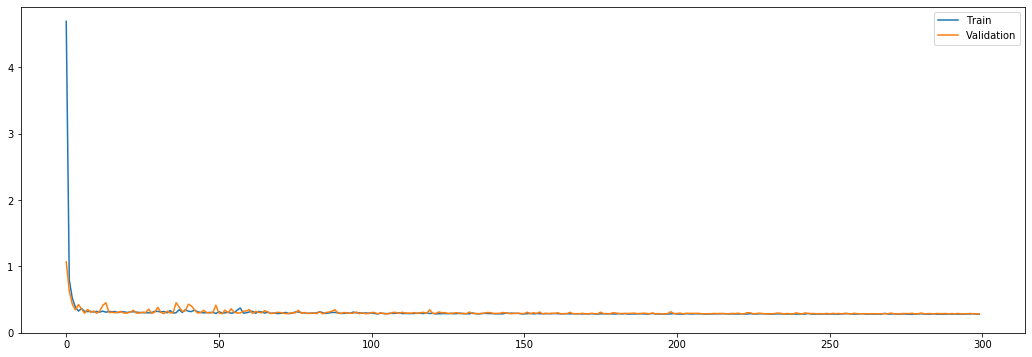

In [50]:
plot_loss(history_dist)

### Compare loss

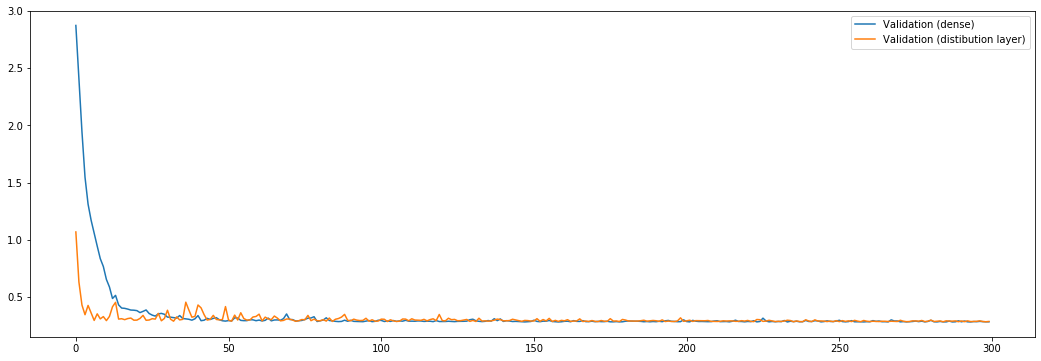

In [51]:
f, ax = plt.subplots(1, 1, figsize=(18, 6))
start_step = 0

# ax.plot(history.history['loss'][start_step:], label="Train (dense)")
ax.plot(history.history['val_loss'][start_step:], label="Validation (dense)")
# ax.plot(history_dist.history['loss'][start_step:], label="Train (distibution layer)")
ax.plot(history_dist.history['val_loss'][start_step:], label="Validation (distibution layer)")
ax.legend()
plt.show()

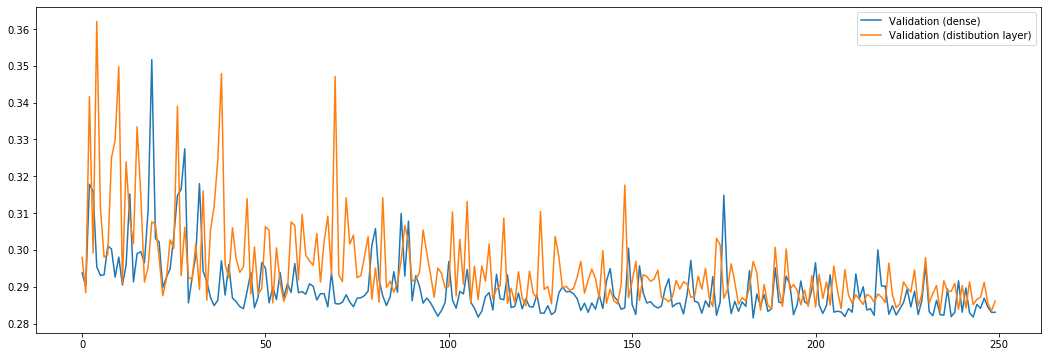

In [52]:
f, ax = plt.subplots(1, 1, figsize=(18, 6))
start_step = 50

# ax.plot(history.history['loss'][start_step:], label="Train (dense)")
ax.plot(history.history['val_loss'][start_step:], label="Validation (dense)")
# ax.plot(history_dist.history['loss'][start_step:], label="Train (distibution layer)")
ax.plot(history_dist.history['val_loss'][start_step:], label="Validation (distibution layer)")
ax.legend()
plt.show()

In [53]:
# "true" quantiles
pd.Series(np.random.normal(0.75, 0.13, size=100000)).quantile(quantiles)

0.005    0.417214
0.025    0.494444
0.165    0.622546
0.250    0.661856
0.500    0.749793
0.750    0.838274
0.835    0.877172
0.975    1.005468
0.995    1.088445
dtype: float64

In [54]:
# "true" quantiles
pd.Series(np.random.normal(1.5, 0.25, size=100000)).quantile(quantiles)

0.005    0.864537
0.025    1.015645
0.165    1.254781
0.250    1.329711
0.500    1.499709
0.750    1.668740
0.835    1.743280
0.975    1.989450
0.995    2.147071
dtype: float64

**Result**: The toy dataset contains two simple distributions, with either $\mu=0.75, \sigma=0.13$ or $\mu=1.5, \sigma=0.25$, depending on whether it is a weekday or weekend. The observed 'demand' are samples distributed as such. For these simple distributions, the Pinball Loss is able to (approximately) retrieve the correct quantiles!